${\Huge \text{OncoKB annotations analysis}}$ <br /><br />
${\Large \text{Pierre Guilmin}}$  
$\text{December 2018}$

**Goal:** This notebook studies the OncoKB annotations added with oncokb-annotator.

This notebook is divided in 7 parts:
* **1. Study of the `oncogenic` feature**
* **2. Create and study the `label` feature**: separate non-somatic, somatic_driver and somatic_passenger
* **3. Study of `cosmic_count` for driver vs non-driver mutations**
* **4. Study of reccurence among driver mutations**
* **5. Study of `is_a_hostpost`, `is_a_3d_hostpot`**
* **6.  Study of `gene_type`**
* **7.  Annotate without oncokb-annotator**: try to annotate our dataset without using oncokb-annotator but using the raw OncoKB dataset instead, and then compare with the oncokb-annotator annotations
* **8.  Study of the alternative amino-acid**: study if the alternative amino-acid changes are also considered by oncokb-annotator

***

In [3]:
source("../../utils/r/custom_tools.R")
setup_environment("../../utils/r")

In [4]:
# load dataset
impact <- read.table("../../data/processed/annotated_final_IMPACT_mutations_20181105.txt",
                     sep = "\t", stringsAsFactors = FALSE, header = TRUE)

# Study of the `oncogenic` feature

Most of our mutations are `Unknown`:

values              count  freq 
1 Unknown             143901 63.9%
2 Likely Oncogenic     60328 26.8%
3 Oncogenic            16566 7.4% 
4 Predicted Oncogenic   3188 1.4% 
5 Inconclusive           651 0.3% 
6 Likely Neutral         388 0.2% 
7 -- total --         225022 100%

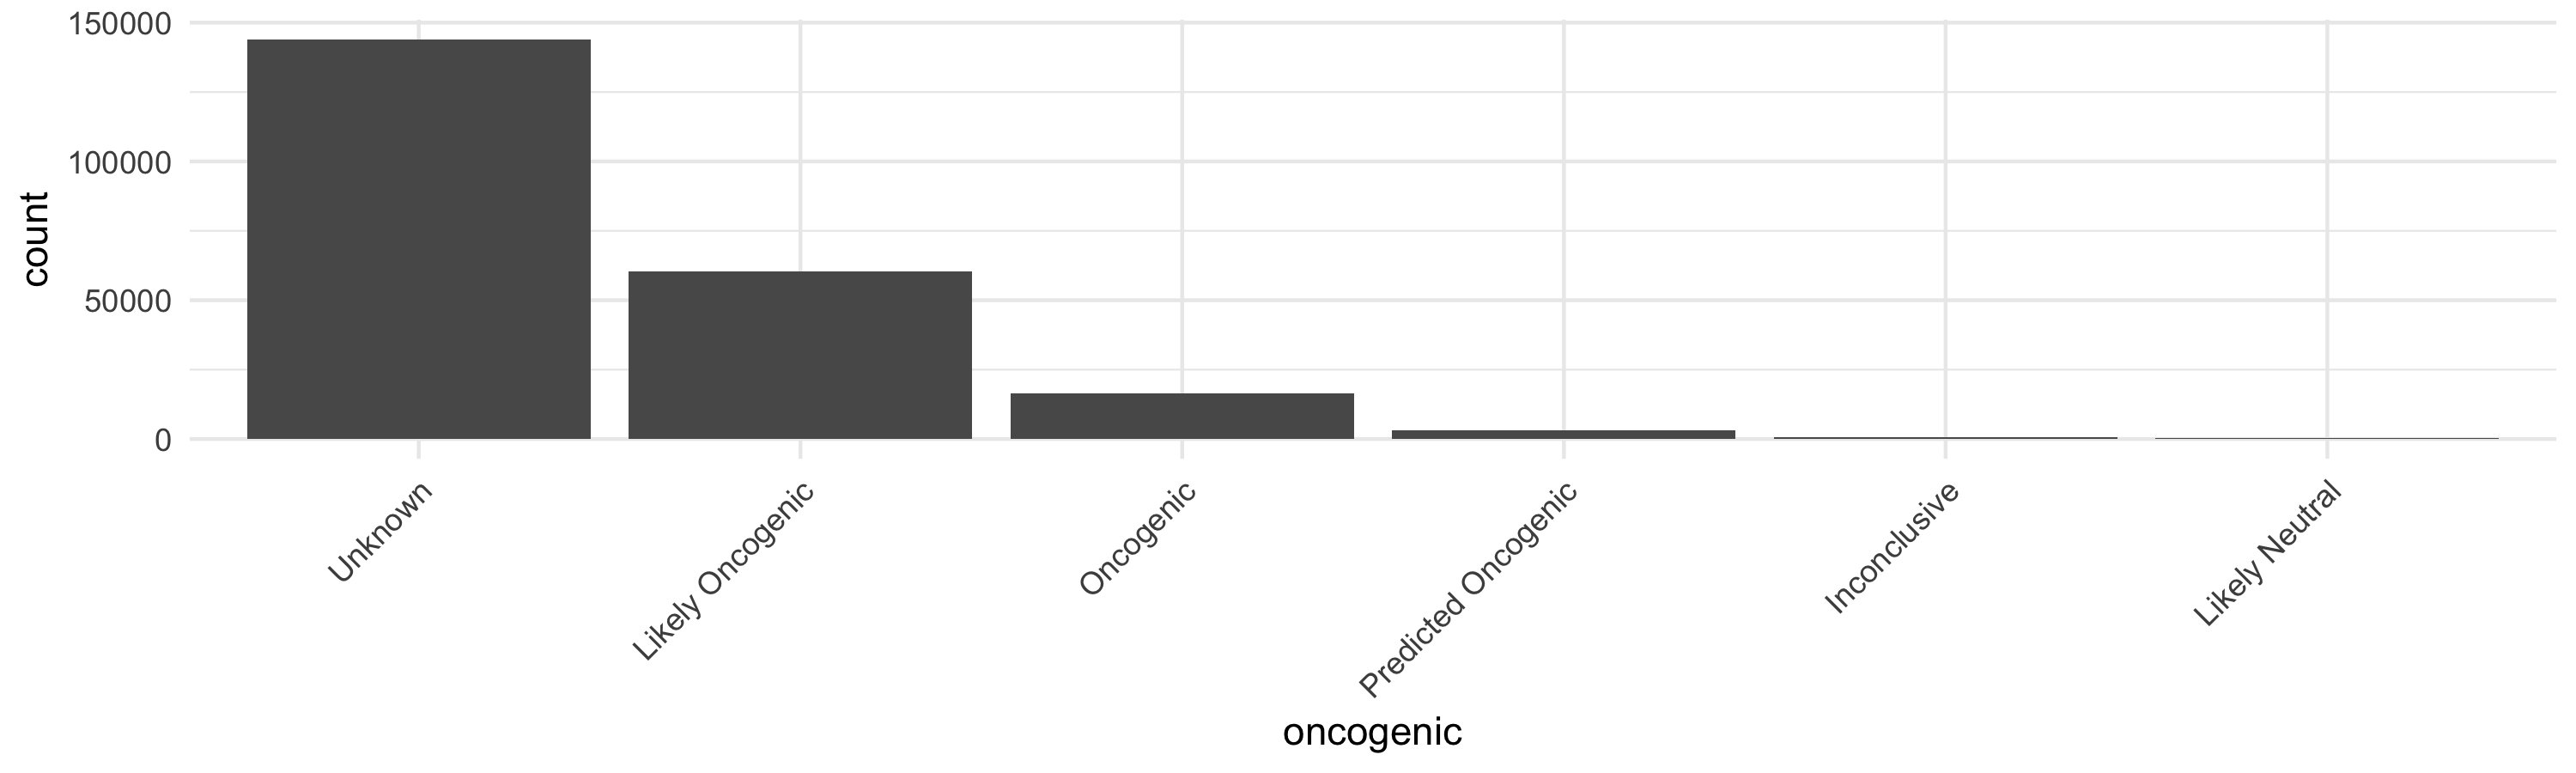

In [5]:
get_table(impact$oncogenic)
plot_histogram(impact, "oncogenic") + tilt_x_label(45)

## `oncogenic` vs `VEP_Consequence`

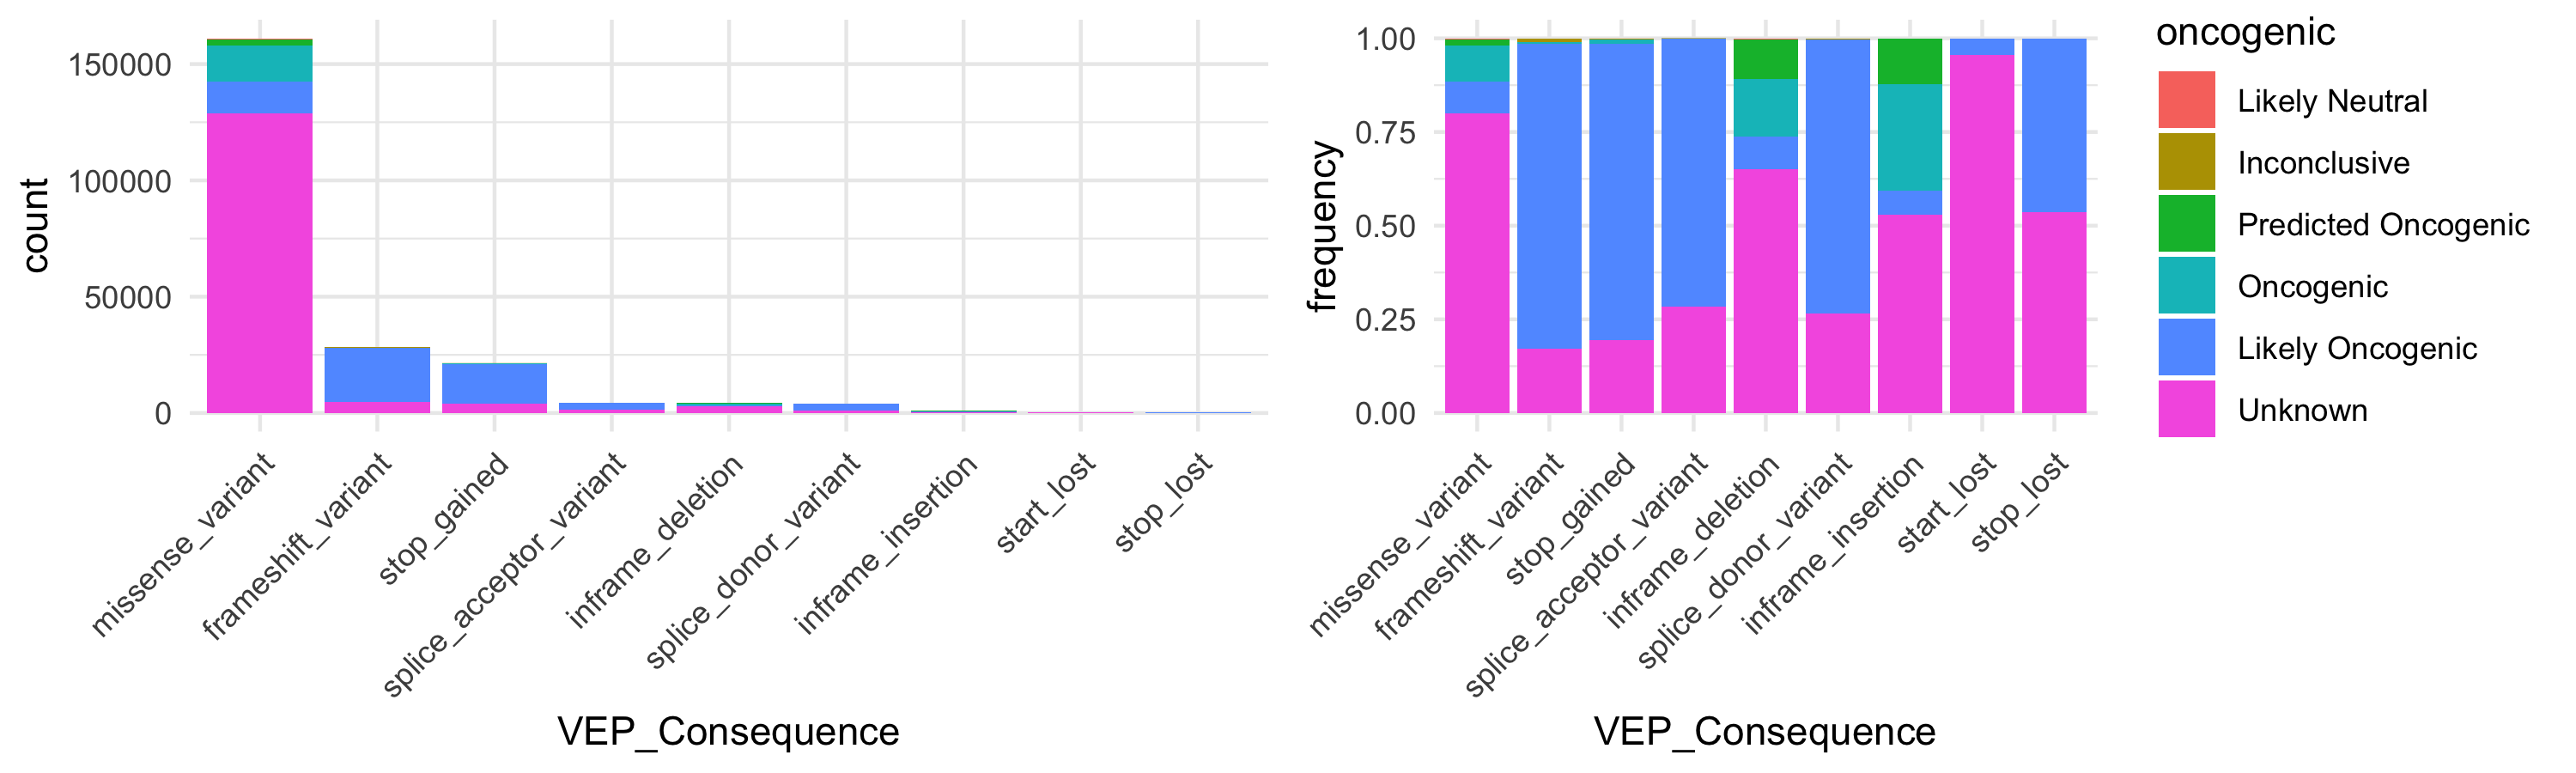

In [6]:
plot_contingency_table_as_histograms(impact, "VEP_Consequence", "oncogenic")

## `oncogenic` vs `class`

In [7]:
# create the class feature
impact$class[impact$confidence_class == "UNLIKELY" ] <- "non-somatic"
impact$class[impact$confidence_class %in% c("AUTO_OK", "MANUAL_OK")] <- "somatic"
get_table(impact$class)

values      count  freq
1 somatic     218173 97% 
2 non-somatic   6849 3%  
3 -- total -- 225022 100%

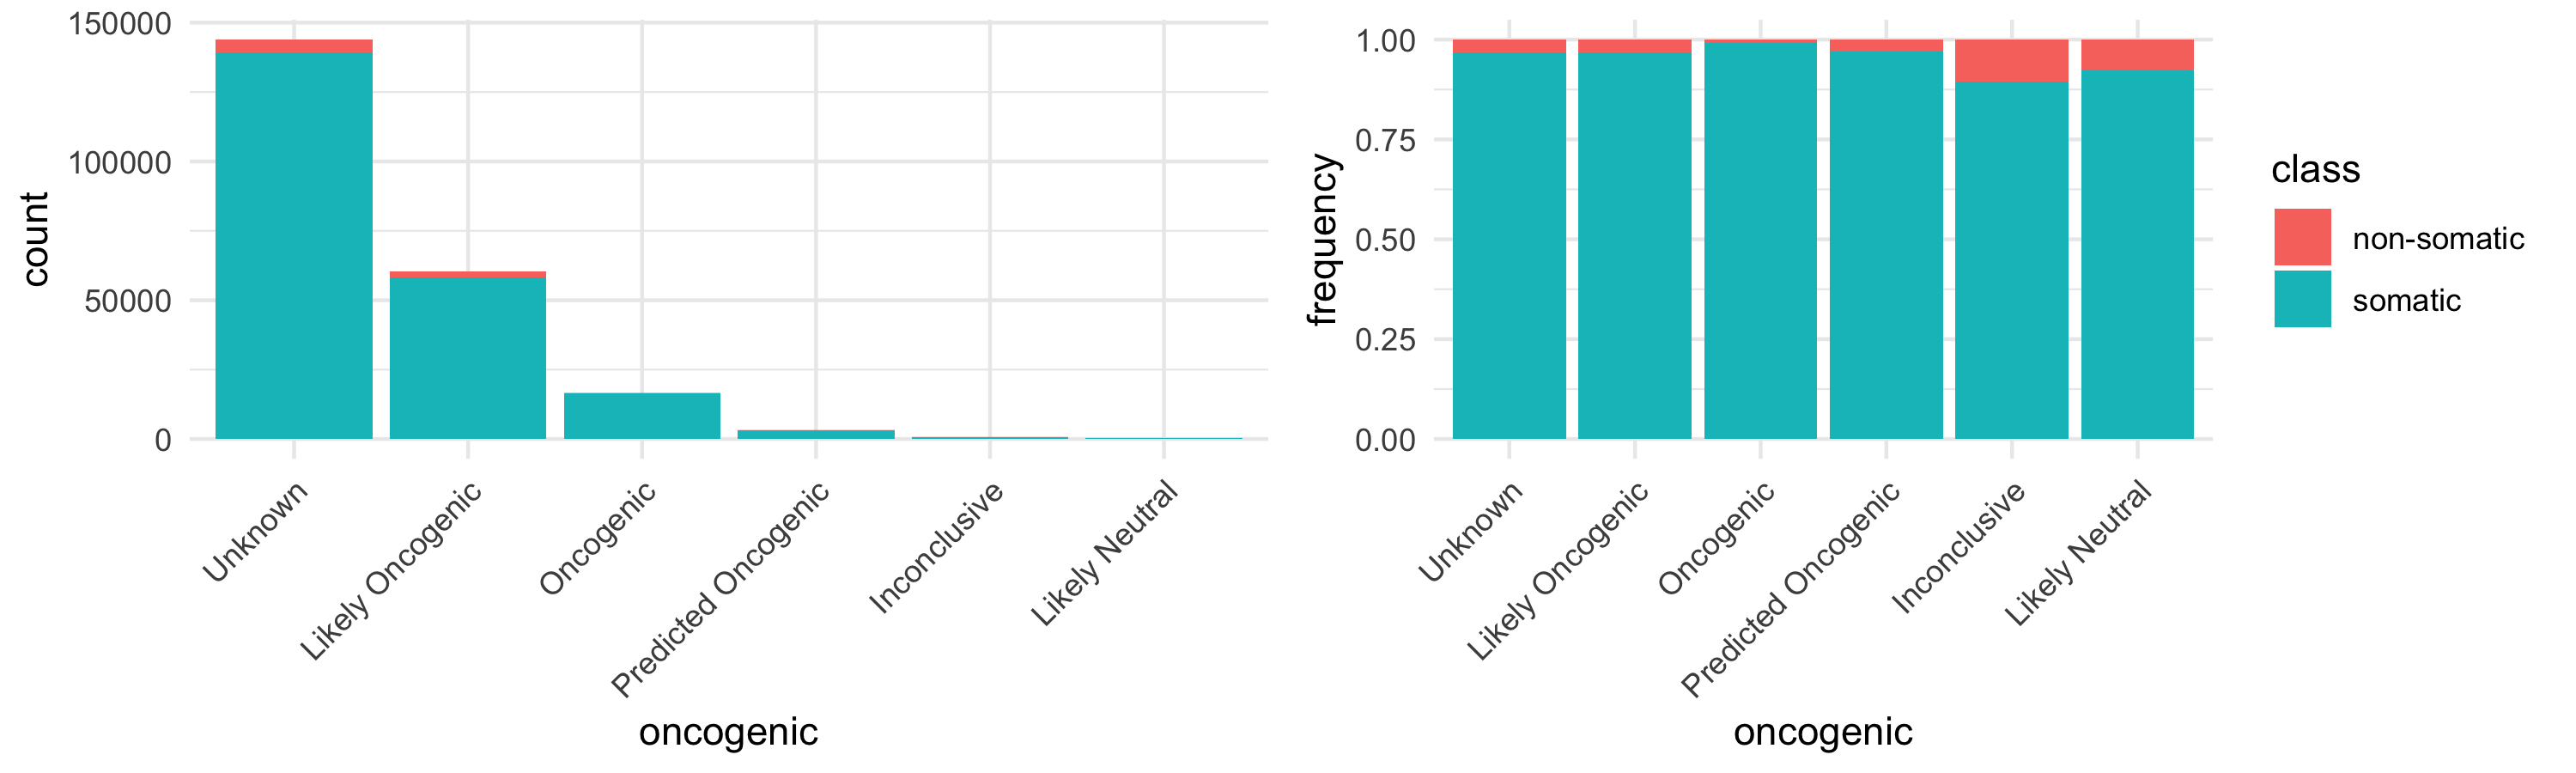

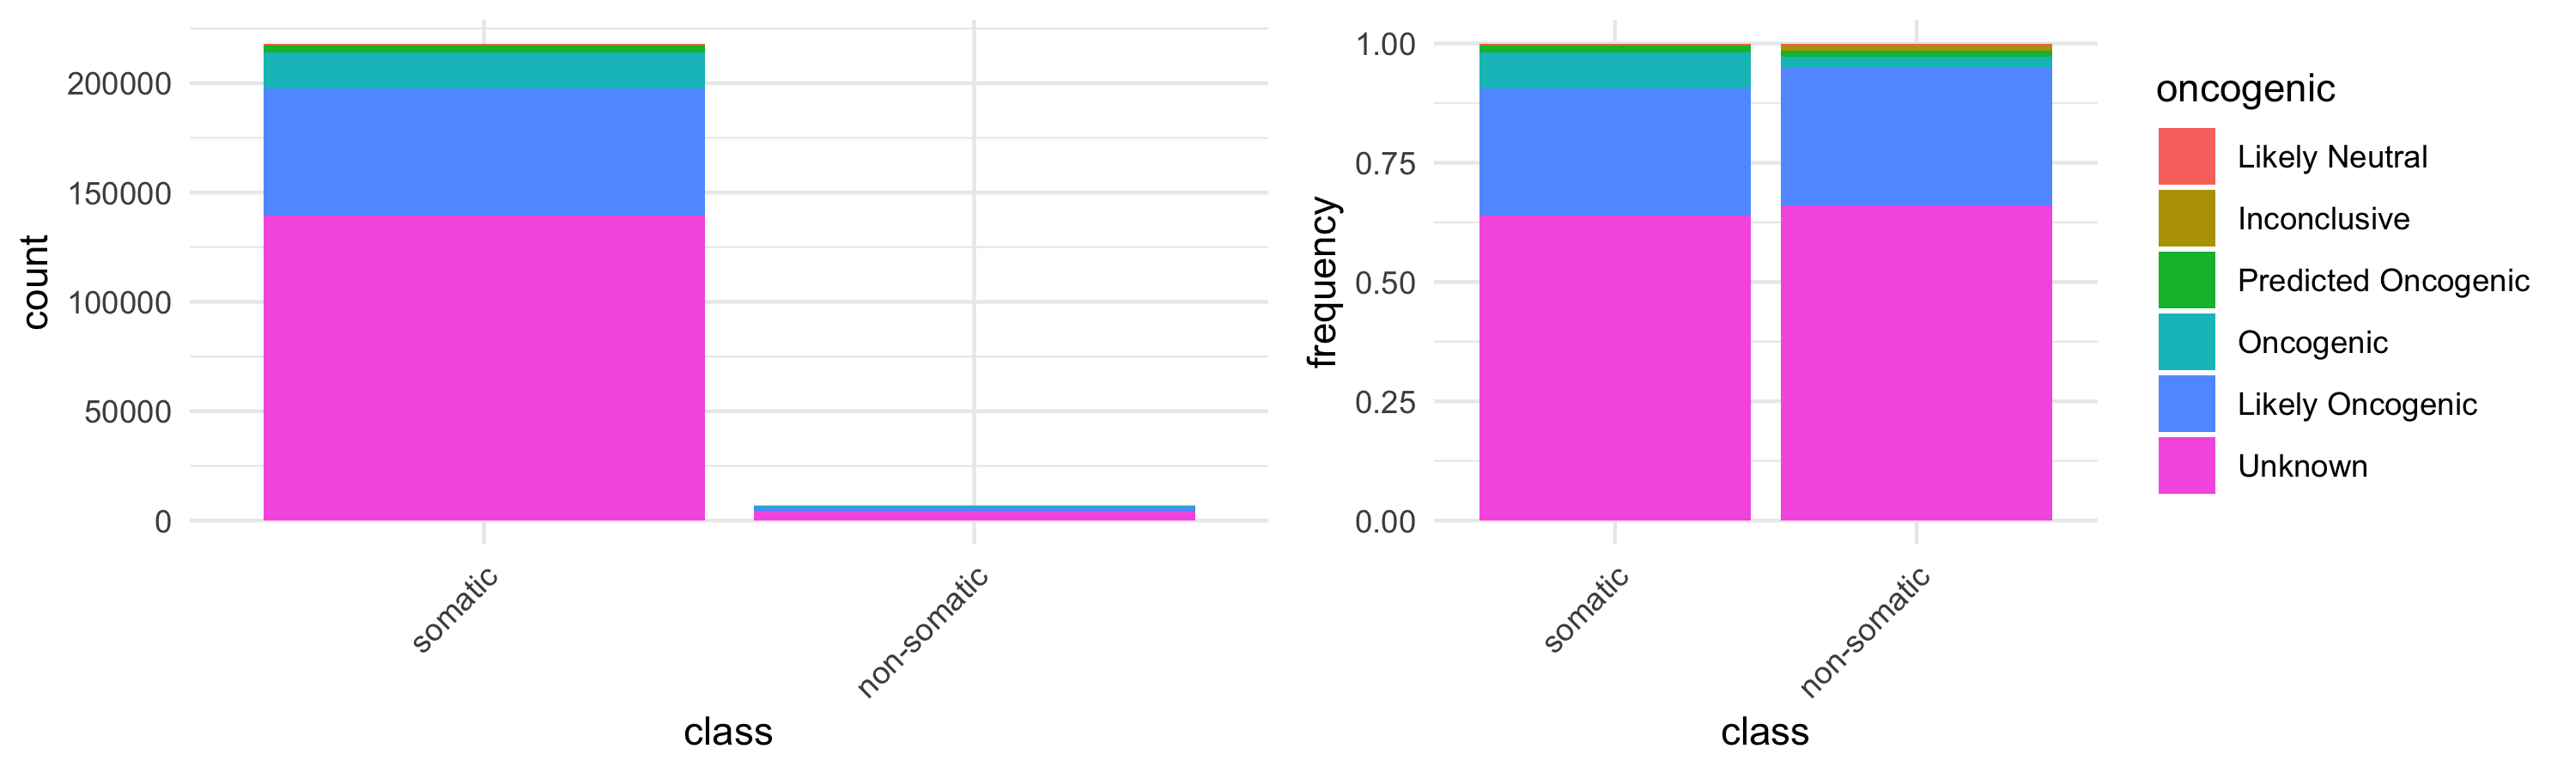

In [8]:
plot_contingency_table_as_histograms(impact, "oncogenic", "class")
plot_contingency_table_as_histograms(impact, "class", "oncogenic")

Some somatic mutations are in OncoKB, however as we saw at the end of [`coding_mutations_analysis.ipynb`](https://github.com/ElsaB/impact-annotator/blob/master/analysis/description/180731_pierre/coding_mutations_analysis.ipynb), there are quite a lot of `non-somatic` mutations (30% of them) that have also been classified as `somatic`:

In [9]:
keys_inconsistent_class <- impact %>% group_by(mut_key) %>%
                                      summarise(n_class = length(unique(class)),
                                                prop_somatic = sum(class == "somatic") / n()) %>%
                                      filter(n_class > 1)

print_count_and_proportion(nrow(impact[impact$class == "non-somatic" &
                                       impact$mut_key %in% keys_inconsistent_class$mut_key,]),
                           nrow(impact[impact$class == "non-somatic",]))

[1] "2568 over 6849 (37.49%)"

In [10]:
dd <- impact
dd$class[dd$class == "non-somatic" & dd$mut_key %in% keys_inconsistent_class$mut_key] <- "uncertain"

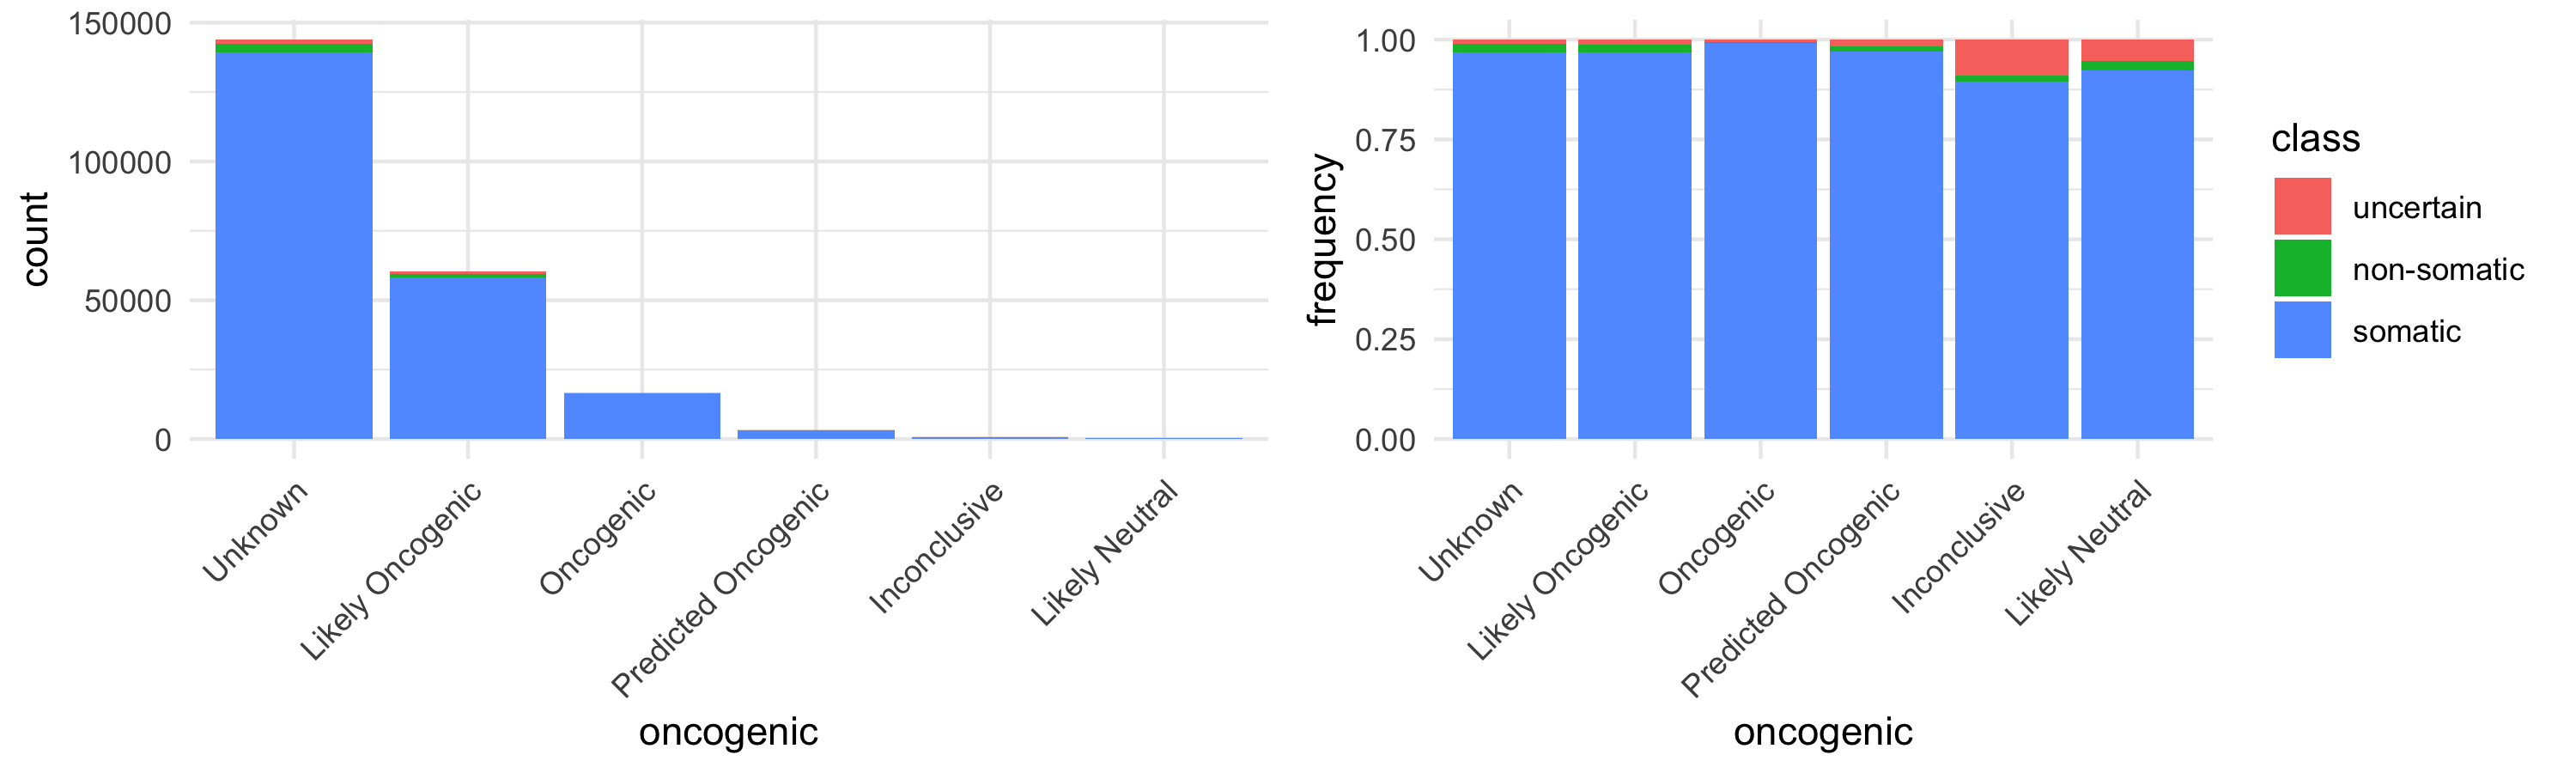

In [11]:
plot_contingency_table_as_histograms(dd, "oncogenic", "class")

In [12]:
nrow(impact[impact$class == "non-somatic" &
            impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic", "Predicted Oncogenic") &
            dd$mut_key %in% keys_inconsistent_class$mut_key,] )

[1] 961

In [13]:
non_somatic_and_driver <- impact[impact$class == "non-somatic" &
                                 impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic", "Predicted Oncogenic"),]

print_count_and_proportion(nrow(non_somatic_and_driver), nrow(impact[impact$class == "non-somatic",]))

[1] "2230 over 6849 (32.56%)"

In [14]:
non_somatic_and_driver <- impact[impact$class == "non-somatic" &
                                 impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic", "Predicted Oncogenic"),]

print_count_and_proportion(nrow(non_somatic_and_driver), nrow(impact))

[1] "2230 over 225022 (0.99%)"

They have a relatively low `VEP_COSMIC_CNT` for the majority ($\leq 2$ for 70% of them):

In [15]:
summary(non_somatic_and_driver$VEP_COSMIC_CNT)
quantile(non_somatic_and_driver$VEP_COSMIC_CNT, c(0.7, 0.8, 0.9, 0.95, 0.99))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0   262.7     6.0 41311.0 

70%     80%     90%     95%     99% 
   4.00   10.00   51.00  136.00 1342.39

## Create the `driver` feature

We create the `driver` feature that indicates if a mutation has been classified as `Oncogenic`, `Likely Oncogenic` or `Predicted Oncogenic` by OncoKB. Around 33% of our mutations are known drivers in OncoKB:

In [16]:
impact$driver <- "no"
impact$driver[impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic", "Predicted Oncogenic")] <- "yes"

print_count_and_proportion(nrow(impact[impact$driver == "yes",]), nrow(impact))

[1] "80082 over 225022 (35.59%)"

Warning: driver mutations include some non-somatic mutations.

# Create and study the `label` feature

## Create the feature

We create the `label` feature that indicates if a mutation is non-somatic, passenger or driver:

In [17]:
impact$label[impact$class == "non-somatic"] <- "non-somatic"
impact$label[impact$class != "non-somatic" & impact$driver == "no" ] <- "somatic_passenger"
impact$label[impact$class != "non-somatic" & impact$driver == "yes"] <- "somatic_driver"

values            count  freq 
1 somatic_passenger 140321 62.4%
2 somatic_driver     77852 34.6%
3 non-somatic         6849 3%   
4 -- total --       225022 100%

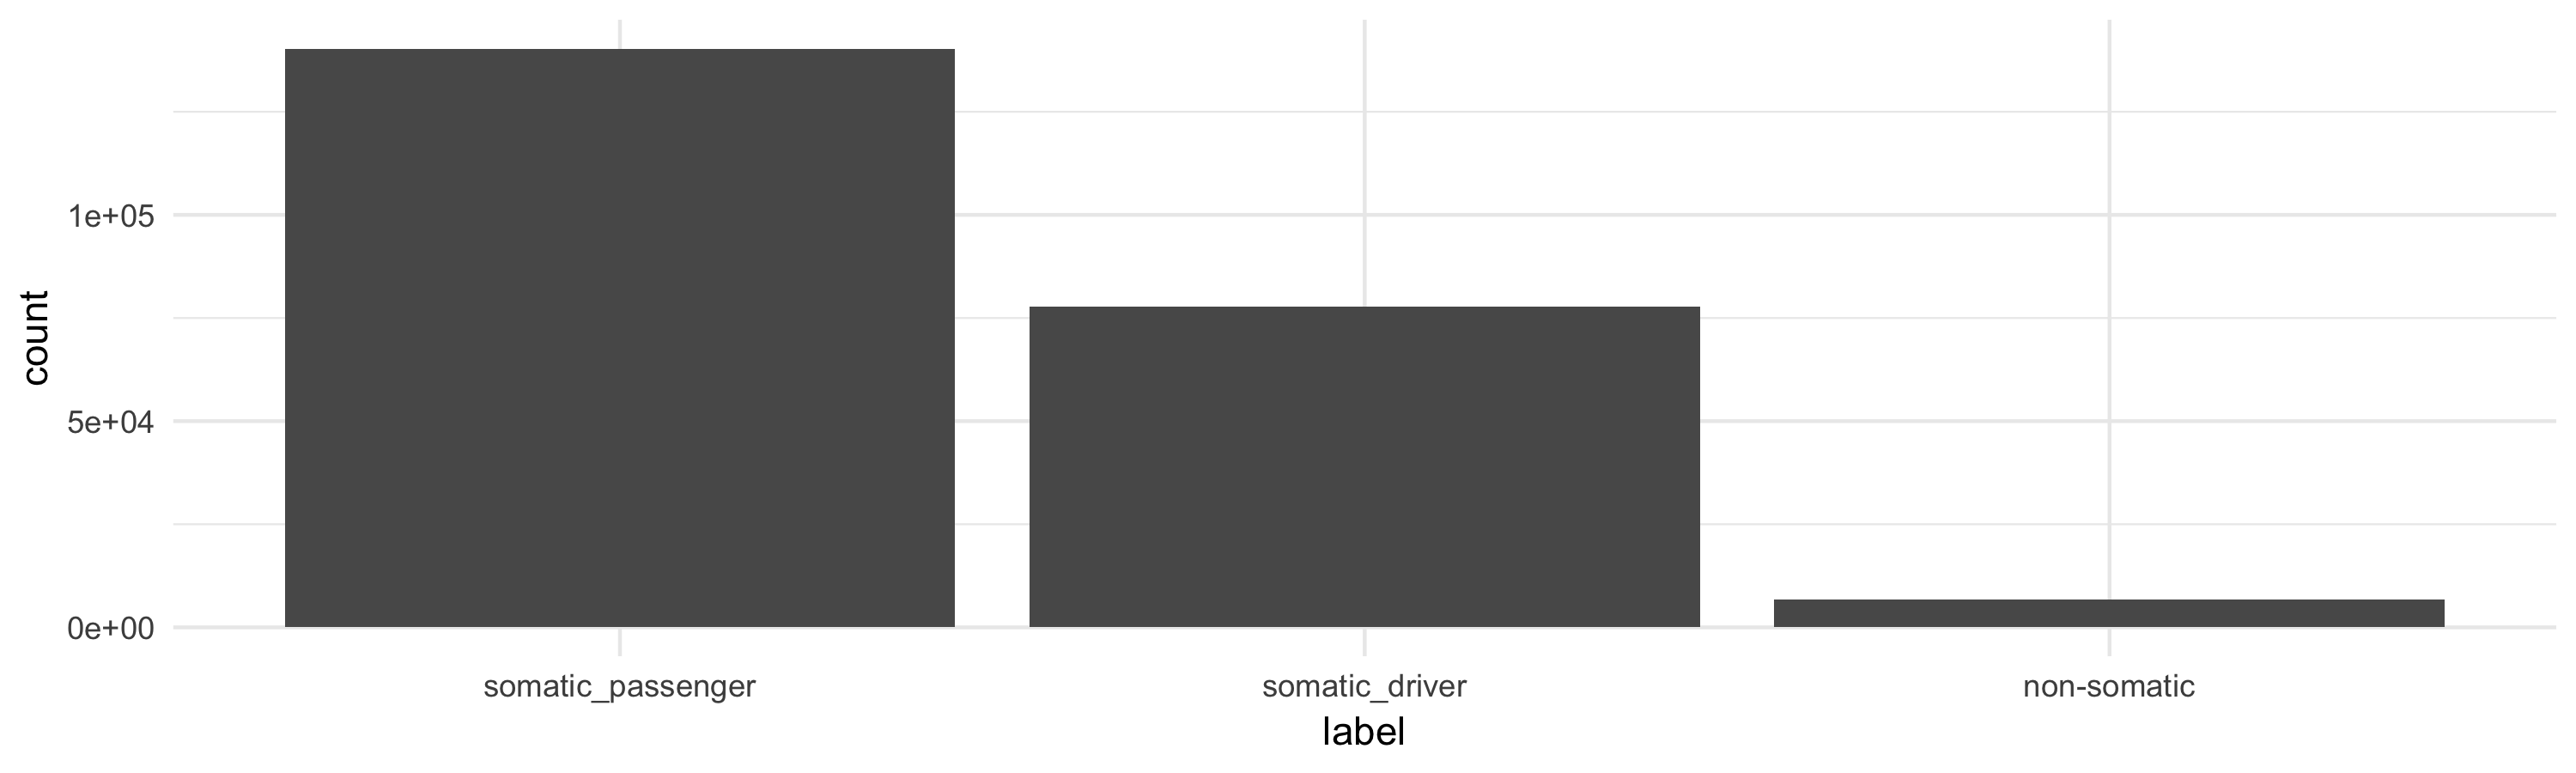

In [18]:
get_table(impact$label)
plot_histogram(impact, "label")

## `label` vs `VEP_Consequence`

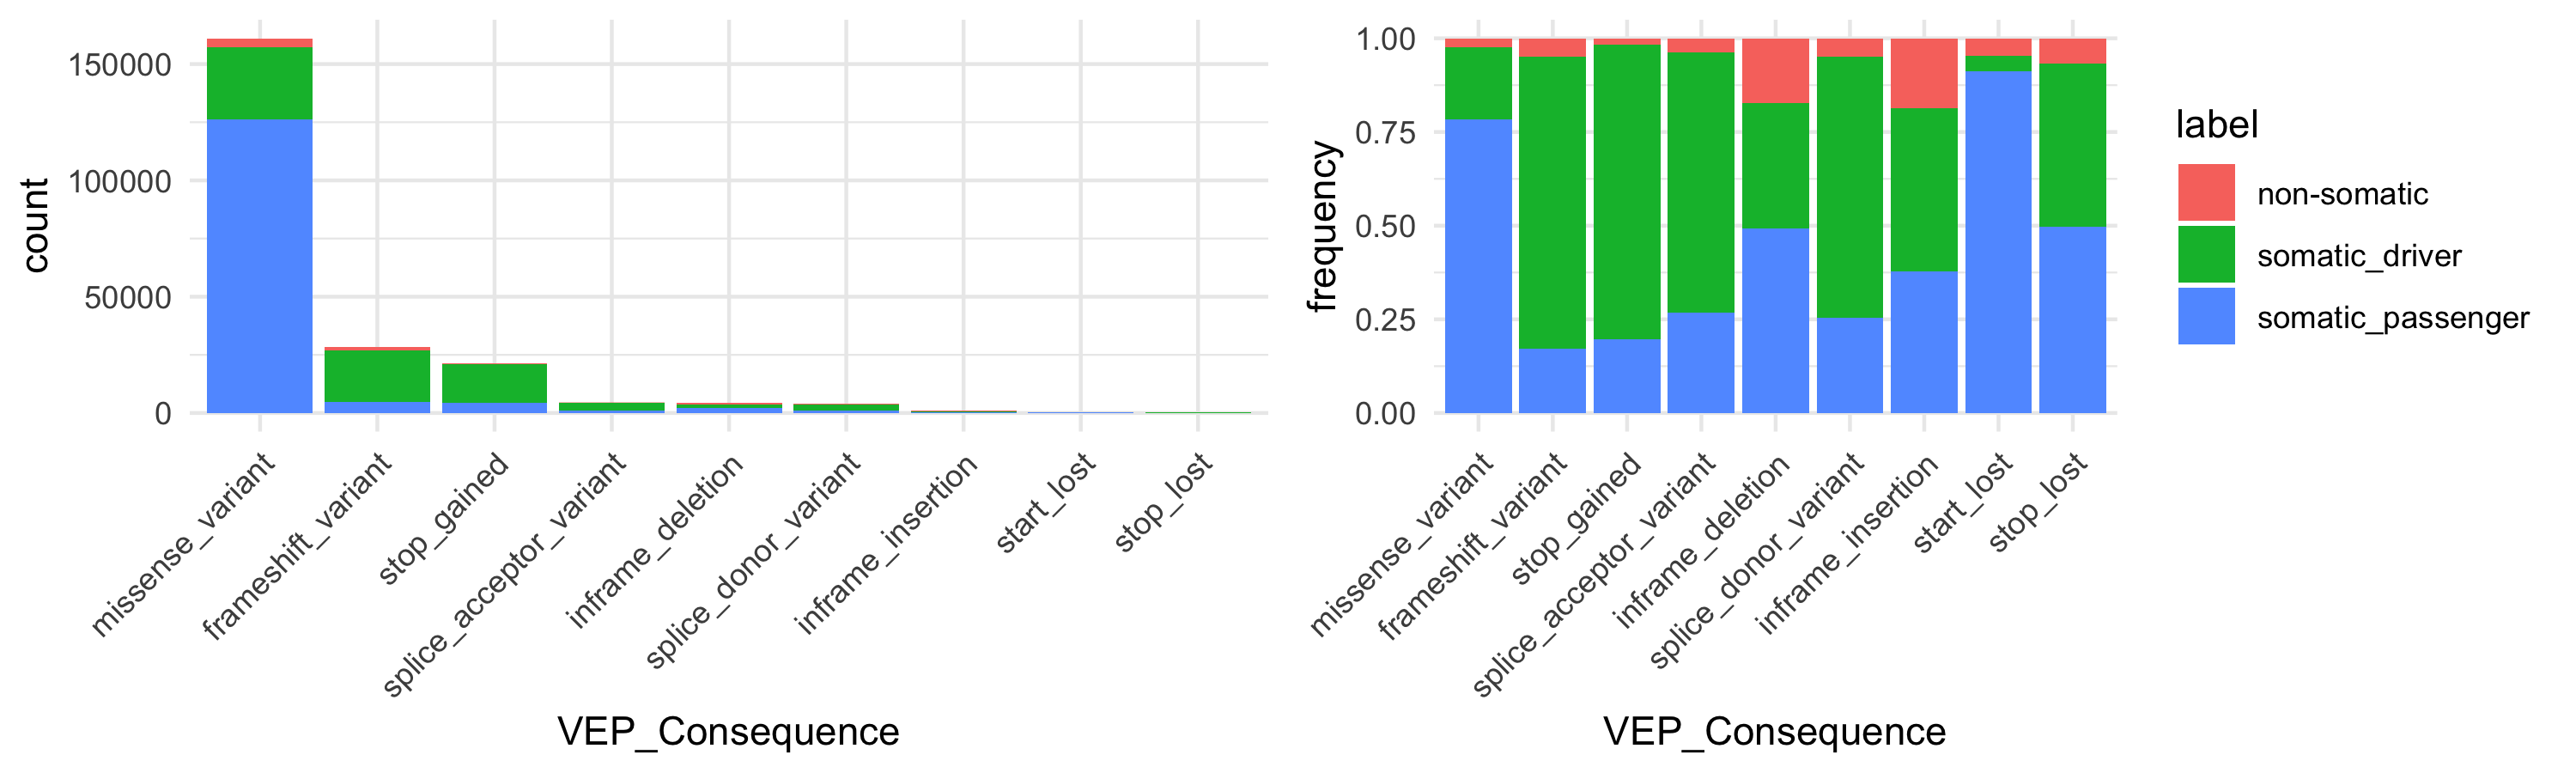

In [19]:
plot_contingency_table_as_histograms(impact, "VEP_Consequence", "label")

# Comparison of the `t_vaf`, `VEP_gnomAD_total_AF` and `VEP_COSMIC_CNT`

In [20]:
impact <- impact[impact$VEP_Consequence != "synonymous_SNV",]

Distribution of `t_vaf`, `VEP_gnomAD_total_AF` and `VEP_COSMIC_CNT` for the different `label` (warning the second and last plot have a sqrt x and sqrt y scale):

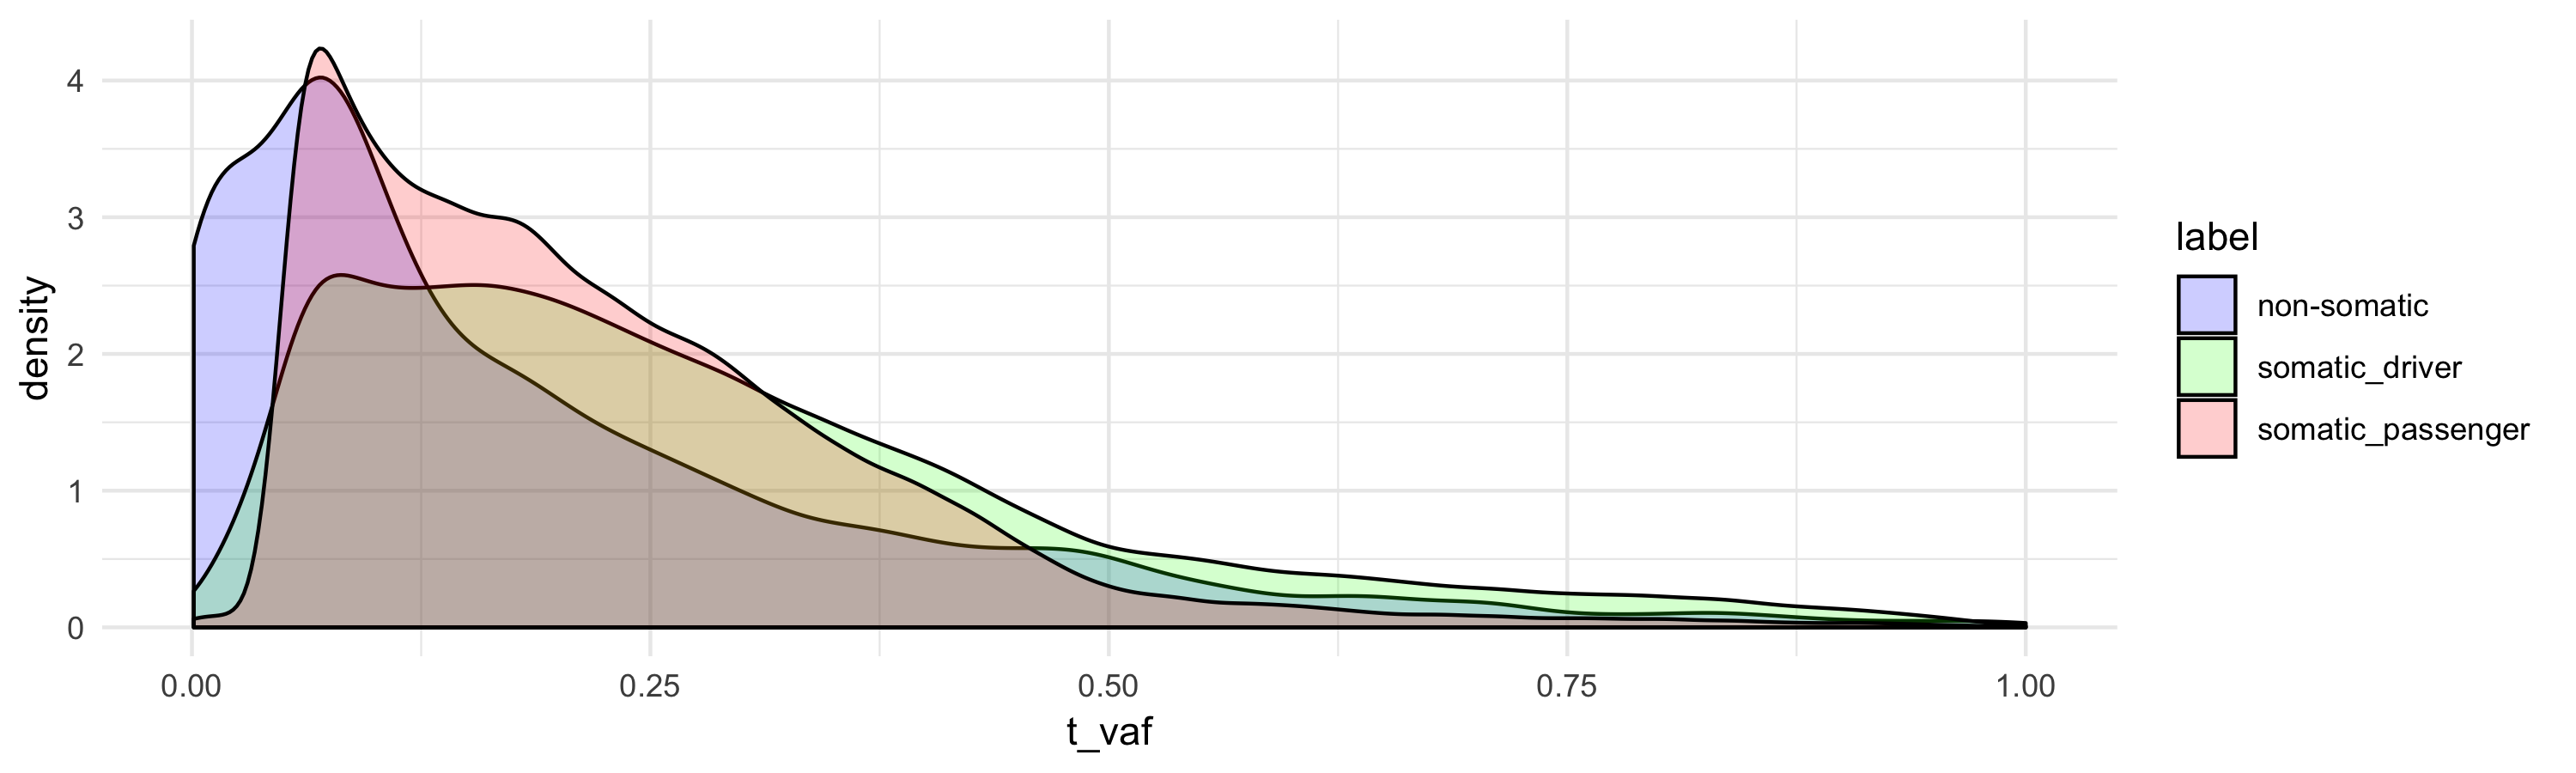

In [21]:
plot_density(impact, "t_vaf", "label")

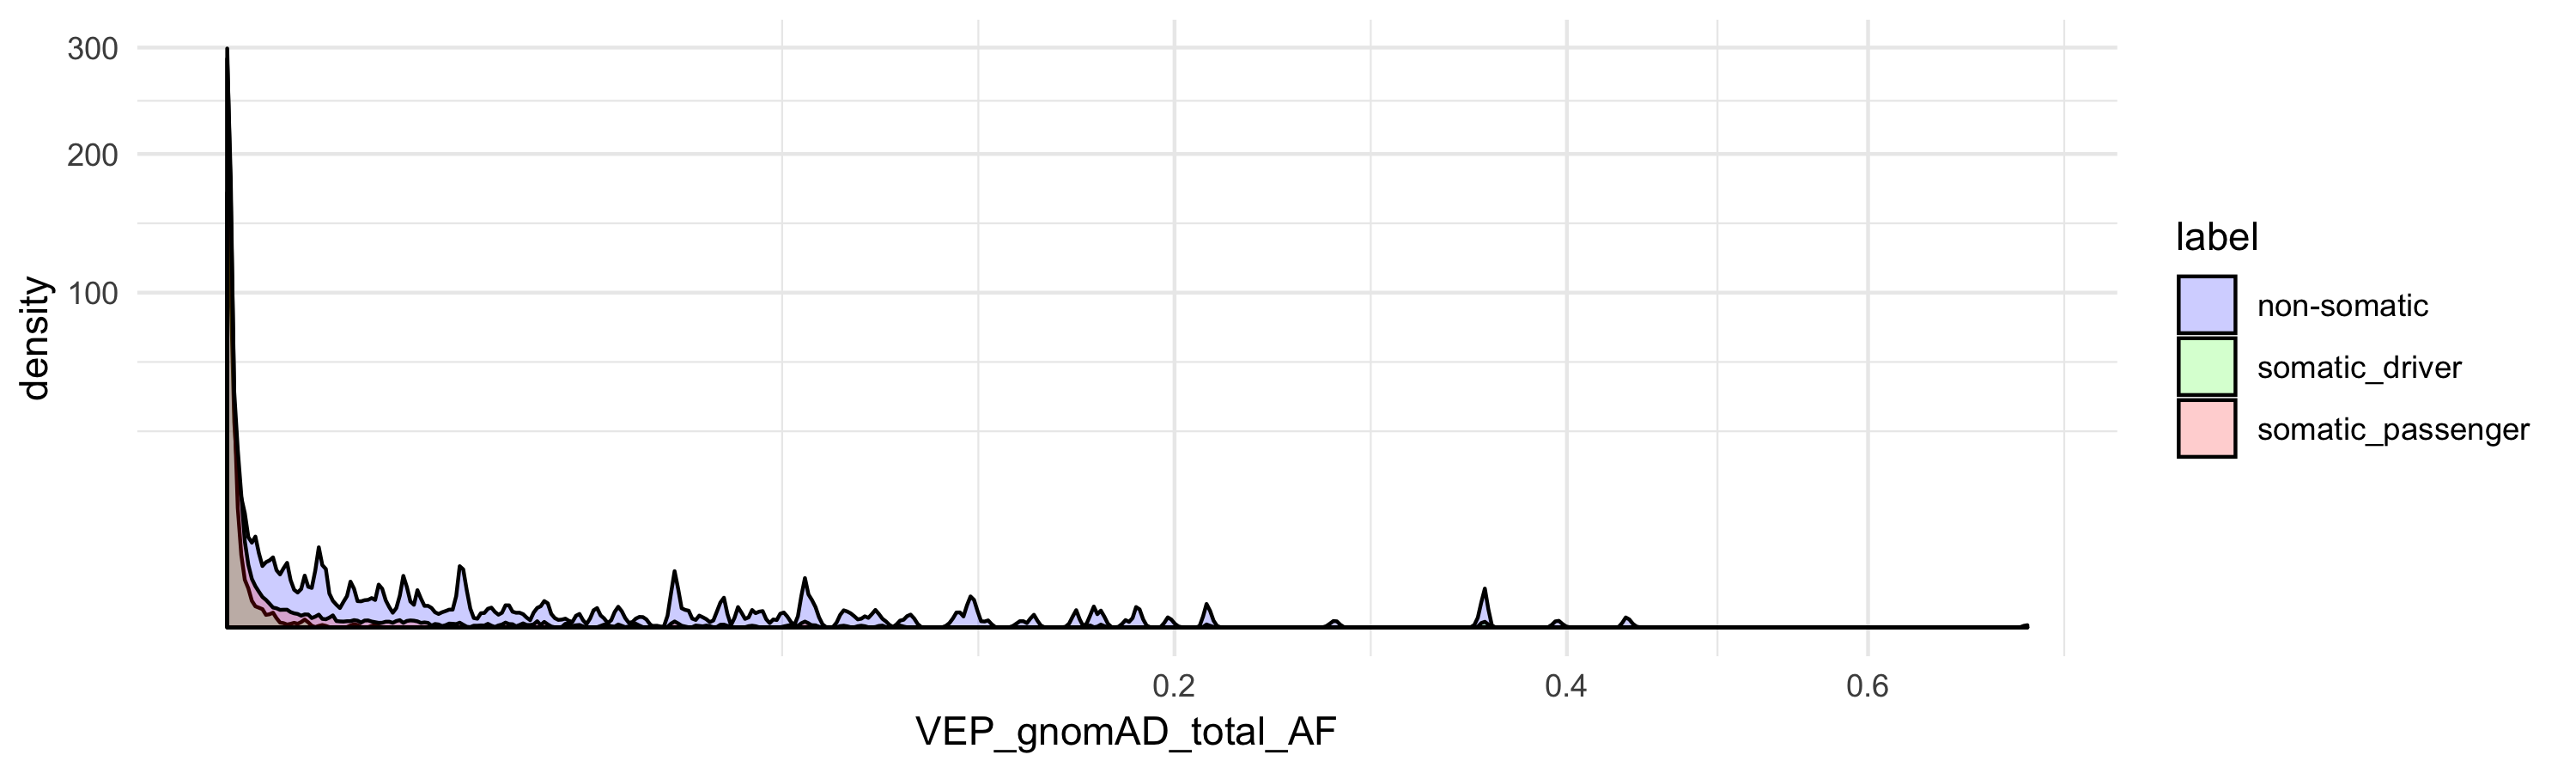

In [22]:
plot_density(impact, "VEP_gnomAD_total_AF", "label") + scale_x_sqrt() + scale_y_sqrt()

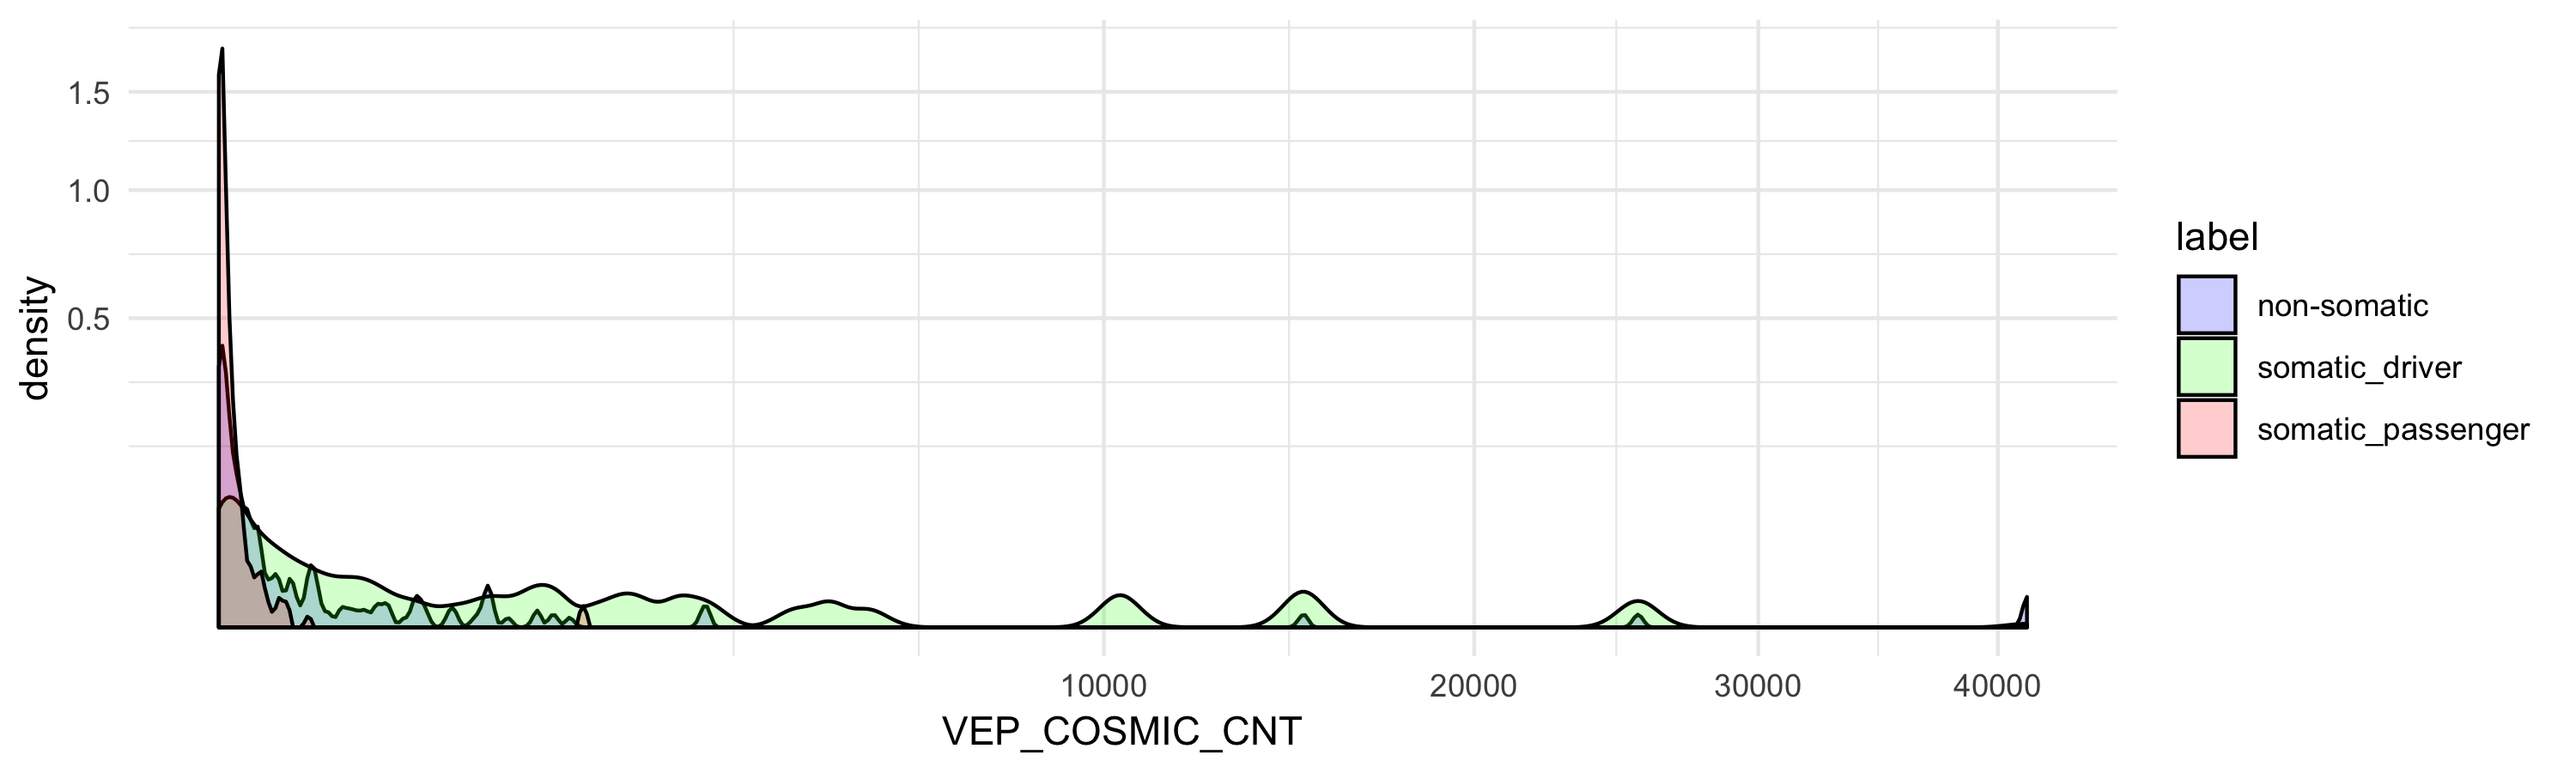

In [23]:
plot_density(impact[impact$VEP_COSMIC_CNT != 0,], "VEP_COSMIC_CNT", "label") + scale_x_sqrt() + scale_y_sqrt()

# Study of `VEP_COSMIC_CNT` for driver vs non-driver mutations

## non-driver mutations

There is not a single variant that is not in OncoKB but have a high `VEP_COSMIC_CNT` (the maximum among non-drivers mutations is 28 but the mean is 0.1423), see the plot of the `VEP_COSMIC_CNT` density below for all the impact mutations and for the non-drivers mutations only (warning this is a sqrt x and y scale):

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0   318.8     2.0 41311.0 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.0000    0.0000    0.0000    0.7769    0.0000 1743.0000 

[1] "3827 over 144940 (2.64%)"

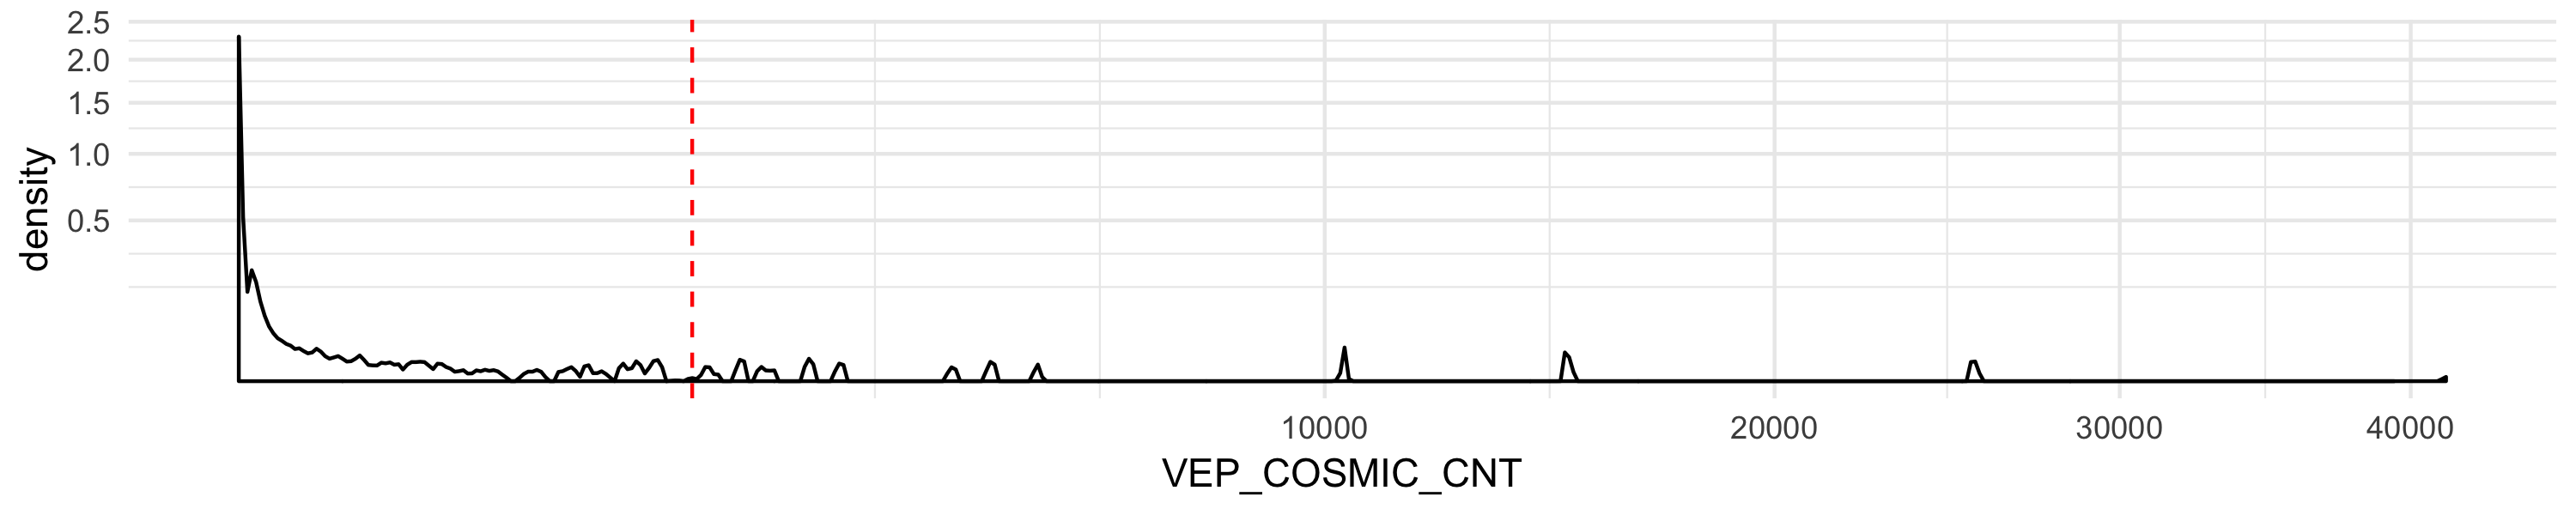

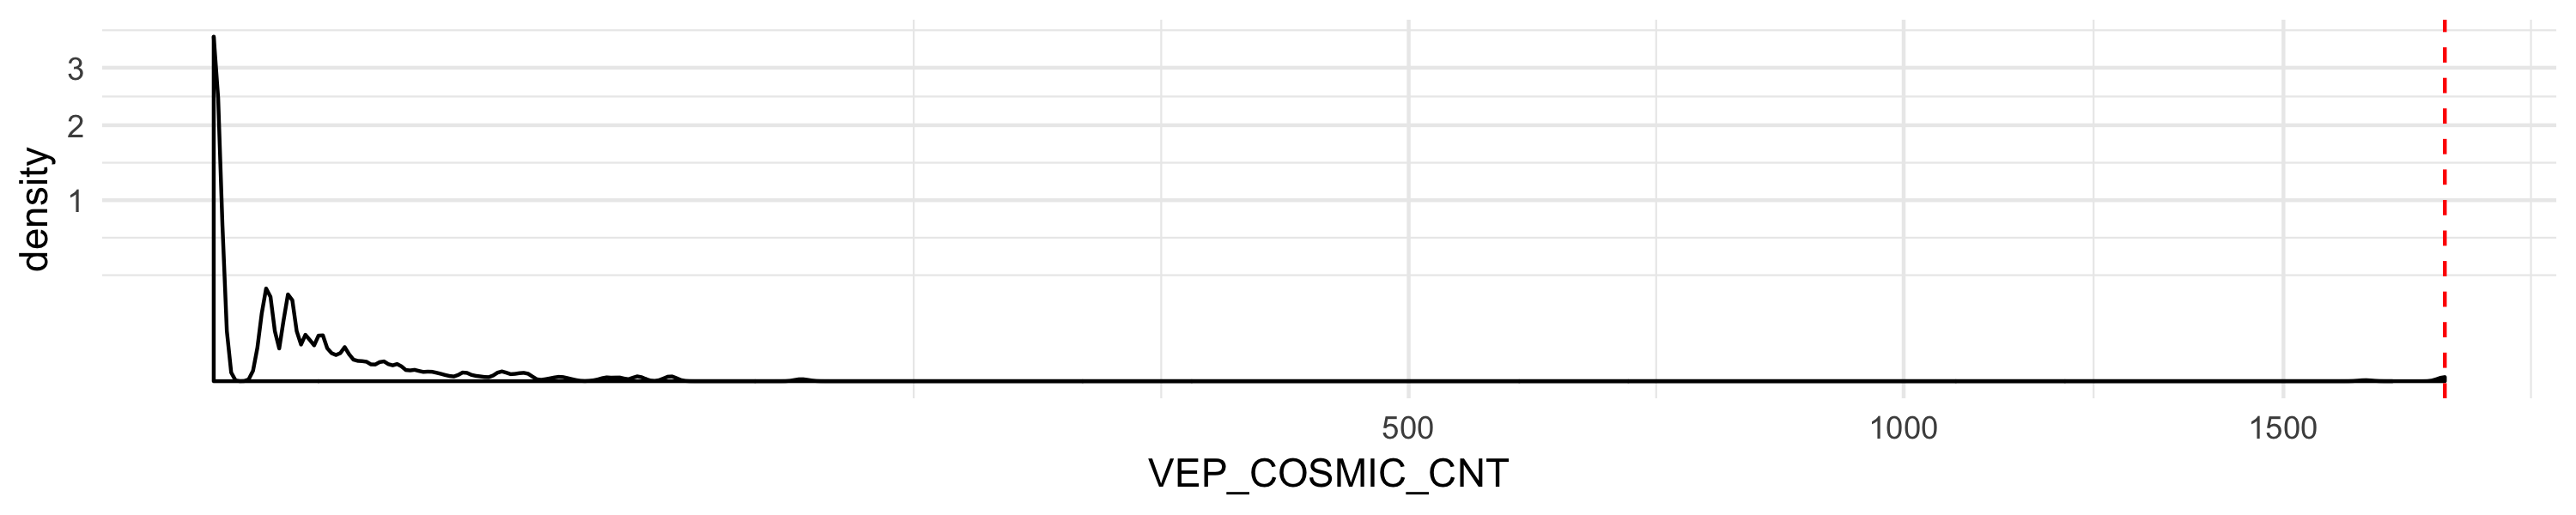

In [24]:
summary(impact$VEP_COSMIC_CNT)
summary(impact[impact$driver == "no",]$VEP_COSMIC_CNT)

# number of non-driver mutations having a cosmic_count >= 10 among the non-driver mutations
print_count_and_proportion(nrow(impact[impact$driver == "no" & impact$VEP_COSMIC_CNT >= 5,]),
                           nrow(impact[impact$driver == "no",]))

max_non_drivers_cosmic_count = max(impact$VEP_COSMIC_CNT[impact$driver == "no"])

plot_density(impact, "VEP_COSMIC_CNT", lines = max_non_drivers_cosmic_count, height = 2) +
        scale_x_sqrt() + scale_y_sqrt()
plot_density(impact[impact$driver == "no",], "VEP_COSMIC_CNT", lines = max_non_drivers_cosmic_count, height = 2) +
        scale_x_sqrt() + scale_y_sqrt()

Low mutation count for the highest `VEP_COSMIC_CNT`:

In [25]:
impact %>% filter(driver == "no" & VEP_COSMIC_CNT >= 50) %>%
           group_by(mut_key) %>%
           summarise(VEP_SYMBOL = unique(VEP_SYMBOL),
                     VEP_HGVSp = unique(VEP_HGVSp),
                     VEP_COSMIC_CNT = unique(VEP_COSMIC_CNT),
                     count = n(),
                     oncogenic = unique(oncogenic)) %>%
           arrange(- VEP_COSMIC_CNT)

mut_key                                                           
1  3_38182641_T_C                                                    
2  19_13054565_GCAGAGGCTTAAGGAGGAGGAAGAAGACAAGAAACGCAAAGAGGAGGAGGAG_-
3  4_1806089_G_T                                                     
4  10_123258034_A_T                                                  
5  9_127912080_G_A                                                   
6  9_8317921_G_A                                                     
7  17_16097825_T_G                                                   
8  4_1807889_A_G                                                     
9  17_16097870_C_A                                                   
10 7_151970859_C_T                                                   
   VEP_SYMBOL VEP_HGVSp    VEP_COSMIC_CNT count oncogenic
1  MYD88      p.*205Rext*8 1743           17    Unknown  
2  CALR       unknown      1621            1    Unknown  
3  FGFR3      p.G372C       121            4    Unknown  
4  FGFR2      p.N550K        73           22    Unknown  
5  PPP6C      p.R301C        63           21    Unknown  
6  PTPRD      p.R1898C       58            4    Unknown  
7  NCOR1      p.Y20S         57            2    Unknown  
8  FGFR3      p.K652E        57            8    Unknown  
9  NCOR1      p.G5V          54           12    Unknown  
10 KMT2C      p.G315S        52            1    Unknown

Relatively low `VEP_COSMIC_CNT` for the high mutation count:

In [26]:
impact %>% filter(driver == "no" & VEP_COSMIC_CNT >= 15) %>%
           group_by(mut_key) %>%
           summarise(VEP_SYMBOL = unique(VEP_SYMBOL),
                     VEP_HGVSp = unique(VEP_HGVSp),
                     VEP_COSMIC_CNT = unique(VEP_COSMIC_CNT),
                     count = n(),
                     oncogenic = unique(oncogenic)) %>%
           filter(count >= 10) %>%
           arrange(- count)

mut_key          VEP_SYMBOL VEP_HGVSp    VEP_COSMIC_CNT count oncogenic   
1  X_66765161_A_T   AR         p.Q58L         29           74    Inconclusive
2  12_416953_T_-    KDM5A      p.G1200Dfs*9   34           59    Unknown     
3  12_57860075_G_-  GLI1       p.G274Afs*6    22           55    Unknown     
4  10_123274774_A_G FGFR2      p.C383R        32           30    Unknown     
5  1_120612013_G_A  NOTCH2     p.A3V          17           24    Unknown     
6  10_123258034_A_T FGFR2      p.N550K        73           22    Unknown     
7  1_36935323_G_-   CSF3R      p.S469Afs*22   16           21    Unknown     
8  9_127912080_G_A  PPP6C      p.R301C        63           21    Unknown     
9  3_38182641_T_C   MYD88      p.*205Rext*8 1743           17    Unknown     
10 3_178927974_G_A  PIK3CA     p.E418K        18           13    Unknown     
11 17_16097870_C_A  NCOR1      p.G5V          54           12    Unknown     
12 9_8518175_C_T    PTPRD      p.E406K        42           12    Unknown

## driver mutations

However, there are variant that are classified as drivers but have a really low `VEP_COSMIC_CNT` (actually 42% of them have a null `VEP_COSMIC_CNT`):

In [27]:
summary(impact[impact$driver == "yes",]$VEP_COSMIC_CNT)

# number of driver mutations having a cosmic_count = 0 among the driver mutations
print_count_and_proportion(nrow(impact[impact$driver == "yes" & impact$VEP_COSMIC_CNT == 0,]),
                           nrow(impact[impact$driver == "yes",]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     3.0   894.5    91.0 41311.0 

[1] "30561 over 80082 (38.16%)"

In [28]:
quantile(impact$VEP_COSMIC_CNT[impact$driver == "yes"], probs = c(0.5, 0.7, 0.8, 0.9))

50%  70%  80%  90% 
   3   48  207 1492

# Study of `VEP_SIFT_score` and `VEP_PolyPhen_score`

Warning message:
“Removed 65545 rows containing non-finite values (stat_density).”

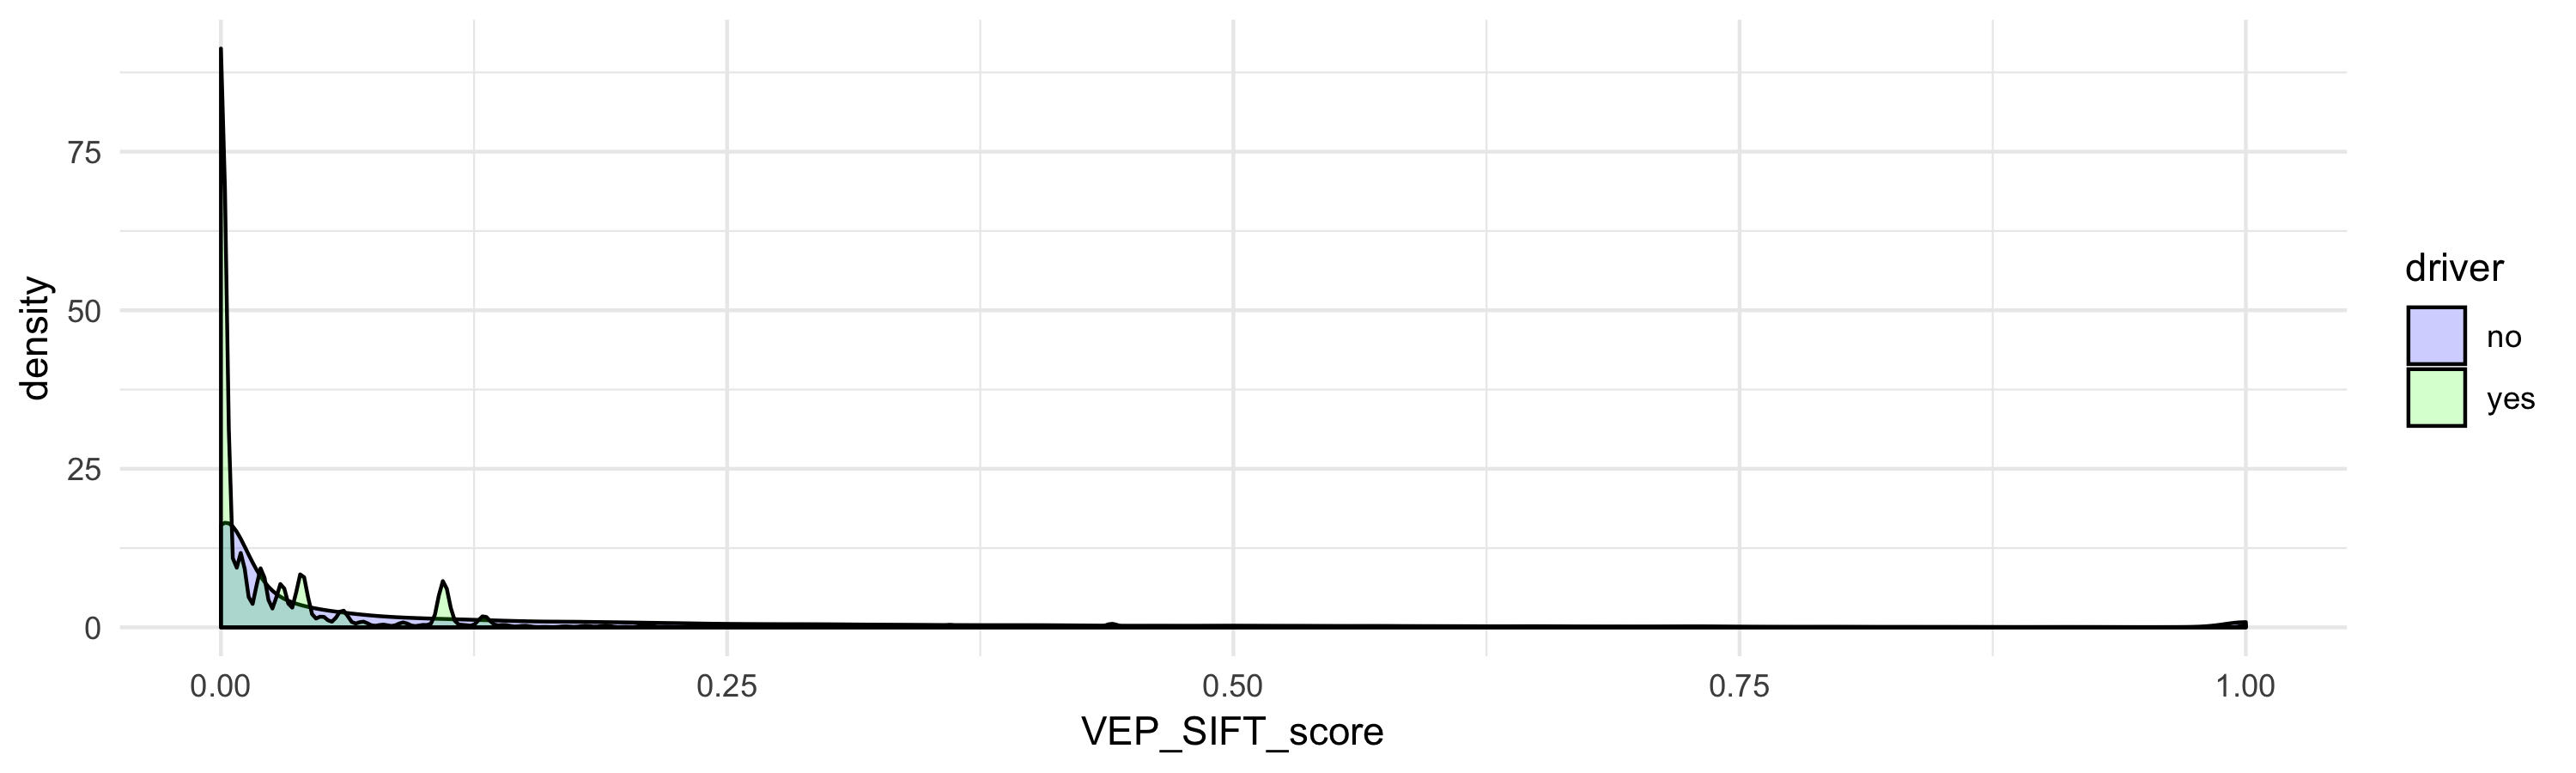

In [62]:
plot_density(impact, "VEP_SIFT_score", "driver")

Warning message:
“Removed 64591 rows containing non-finite values (stat_density).”

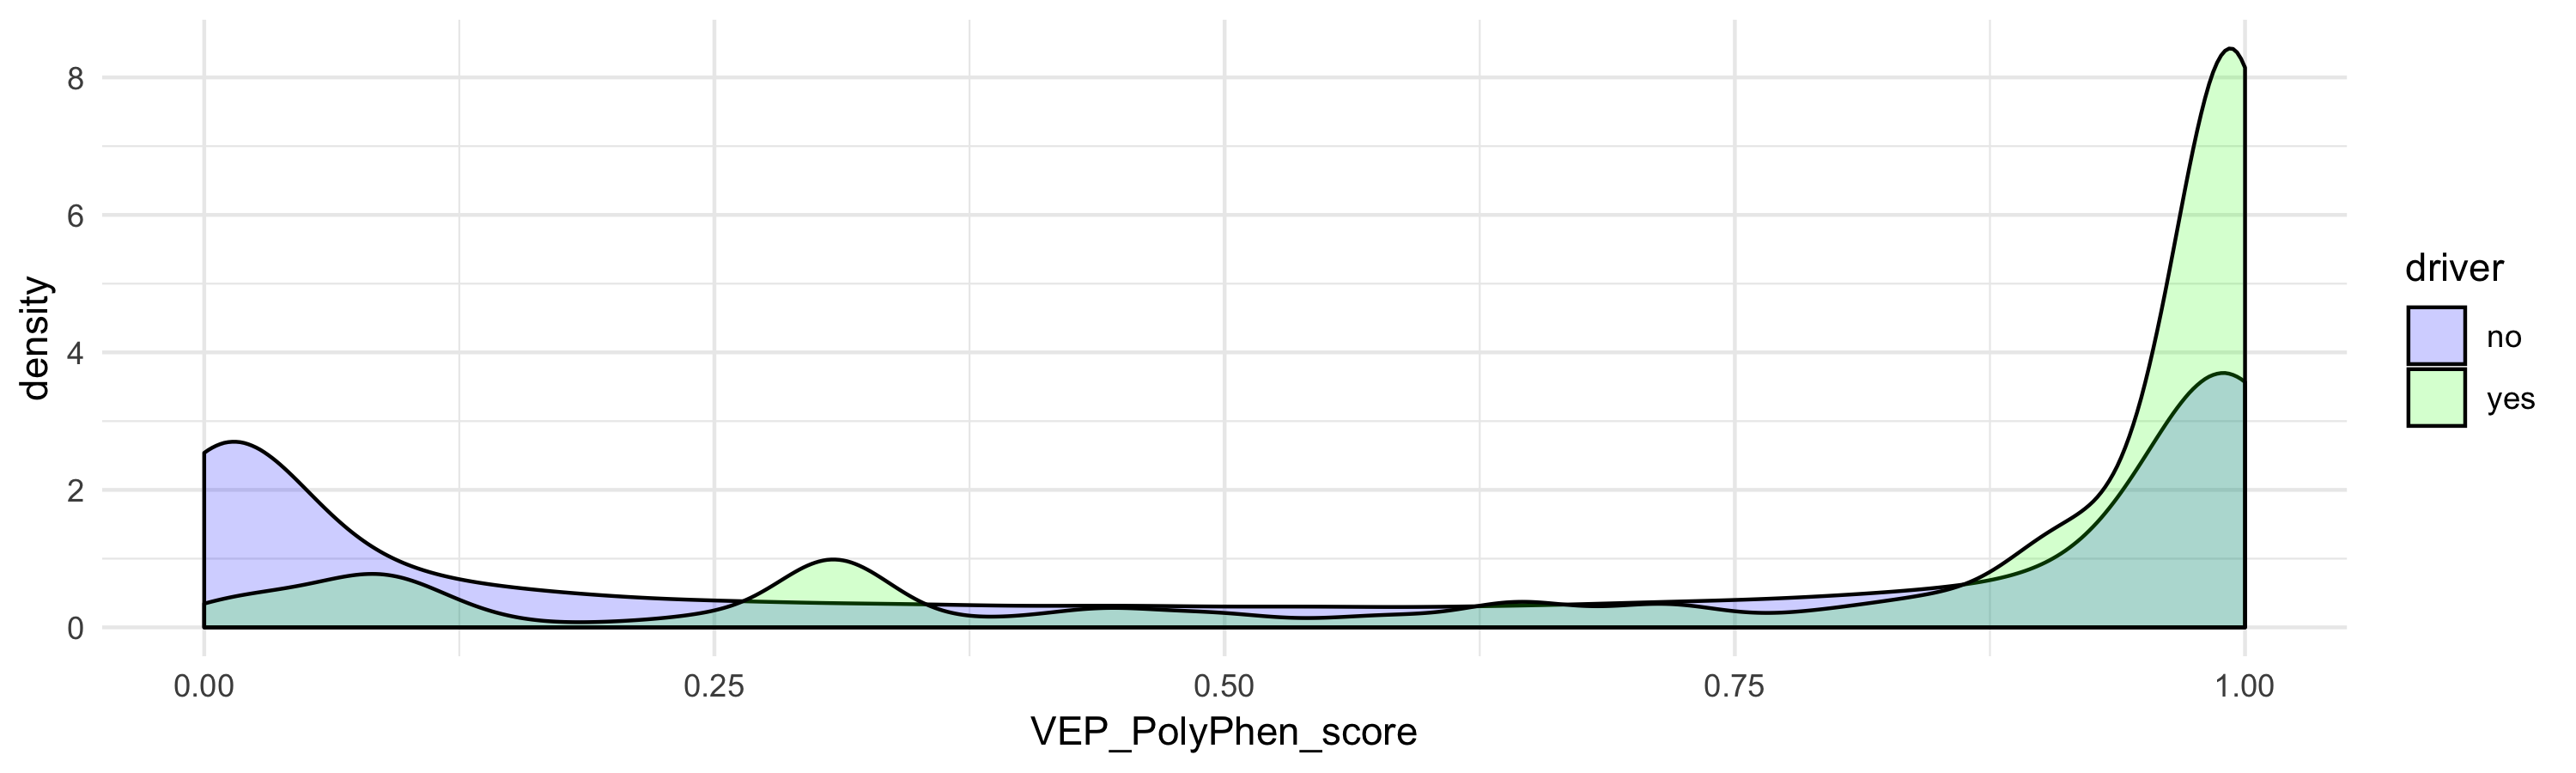

In [63]:
plot_density(impact, "VEP_PolyPhen_score", "driver")

# Study of reccurence among driver mutations

We will follow the methodology from `coding_mutations_analysis.ipynb`.

## Identify the reccurent mutations

We need to study the reccurence of mutations taking care not to consider a mutation as recurrent if it comes frome the same patient. To do so we will group the rows by patient, and select only the distinct mutations for each patient:

In [29]:
impact_unique_mut_keys_per_patient <- as.data.frame(impact %>% group_by(patient_key) %>%
                                                               select(patient_key,
                                                                      mut_key,
                                                                      VEP_SYMBOL,
                                                                      VEP_Consequence,
                                                                      VEP_VARIANT_CLASS,
                                                                      class,
                                                                      driver,
                                                                      oncogenic) %>%
                                                               filter(! duplicated(mut_key)))
head(impact_unique_mut_keys_per_patient)

patient_key mut_key         VEP_SYMBOL VEP_Consequence        
1 P-0000012   17_7577515_T_G  TP53       missense_variant       
2 P-0000012   1_46521514_G_C  PIK3R3     missense_variant       
3 P-0000012   3_142178126_C_A ATR        missense_variant       
4 P-0000012   4_55139732_T_A  PDGFRA     missense_variant       
5 P-0000012   4_153249542_C_A FBXW7      splice_acceptor_variant
6 P-0000012   4_153332775_C_A FBXW7      stop_gained            
  VEP_VARIANT_CLASS class   driver oncogenic       
1 SNV               somatic yes    Likely Oncogenic
2 SNV               somatic no     Unknown         
3 SNV               somatic no     Unknown         
4 SNV               somatic no     Unknown         
5 SNV               somatic yes    Likely Oncogenic
6 SNV               somatic yes    Likely Oncogenic

In [30]:
drivers <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$driver == "yes",]
print_count_and_proportion(nrow(drivers), nrow(impact_unique_mut_keys_per_patient))

[1] "76054 over 215867 (35.23%)"

In [31]:
mut_key_info <- as.data.frame(drivers %>% group_by(mut_key) %>% summarise(count = n(),
                                                                          VEP_SYMBOL = unique(VEP_SYMBOL)))
head(mut_key_info)

mut_key        count VEP_SYMBOL
1 1_11168338_C_T 1     MTOR      
2 1_11169361_C_G 1     MTOR      
3 1_11169375_A_C 1     MTOR      
4 1_11169376_A_T 3     MTOR      
5 1_11169377_T_A 3     MTOR      
6 1_11174395_A_C 4     MTOR

In [32]:
for (threshold in c(2, 3, 5, 10)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$count >= threshold,]
    
    impact_unique_mut_keys_per_patient_threshold <- impact_unique_mut_keys_per_patient[
                                                            impact_unique_mut_keys_per_patient$mut_key
                                                            %in% mut_key_info_threshold$mut_key,]
    
    print(sprintf("%s keys are shared by at least %2d samples [%s rows concerned]",
                  print_count_and_proportion(nrow(mut_key_info_threshold), nrow(mut_key_info), 5, 5),
                  threshold,
                  print_count_and_proportion(nrow(impact_unique_mut_keys_per_patient_threshold),
                                             nrow(impact_unique_mut_keys_per_patient))))
}

[1] " 6979 over 32298 (21.61%) keys are shared by at least  2 samples [50735 over 215867 (23.50%) rows concerned]"
[1] " 3726 over 32298 (11.54%) keys are shared by at least  3 samples [44229 over 215867 (20.49%) rows concerned]"
[1] " 1946 over 32298 ( 6.03%) keys are shared by at least  5 samples [38252 over 215867 (17.72%) rows concerned]"
[1] "  832 over 32298 ( 2.58%) keys are shared by at least 10 samples [31197 over 215867 (14.45%) rows concerned]"


Distribution of the mutations key count for the mutations present in at least 2 samples (warning this is a sqrt x and y scale):

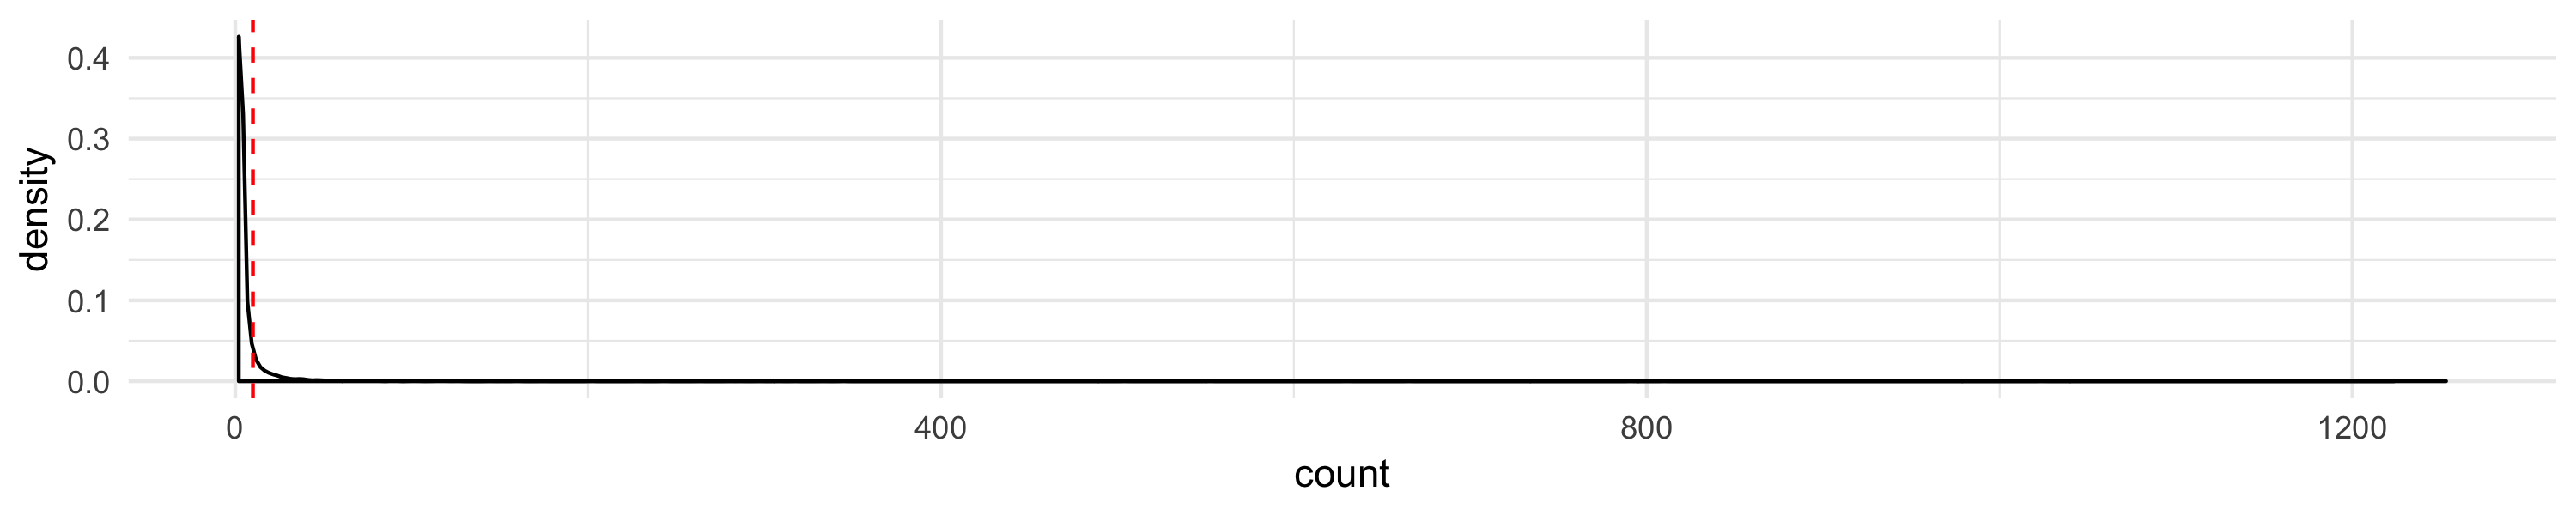

In [33]:
repeated_key <- mut_key_info[mut_key_info$count >= 2,] # keys shared by at least 2 samples
plot_density(repeated_key, "count", lines = 10, height = 2)

## Sudy the reccurent mutations genes

In [34]:
length(unique(repeated_key$VEP_SYMBOL))

[1] 292

Here is a plot of the genes that are the most mutated **accross the mutation keys**:

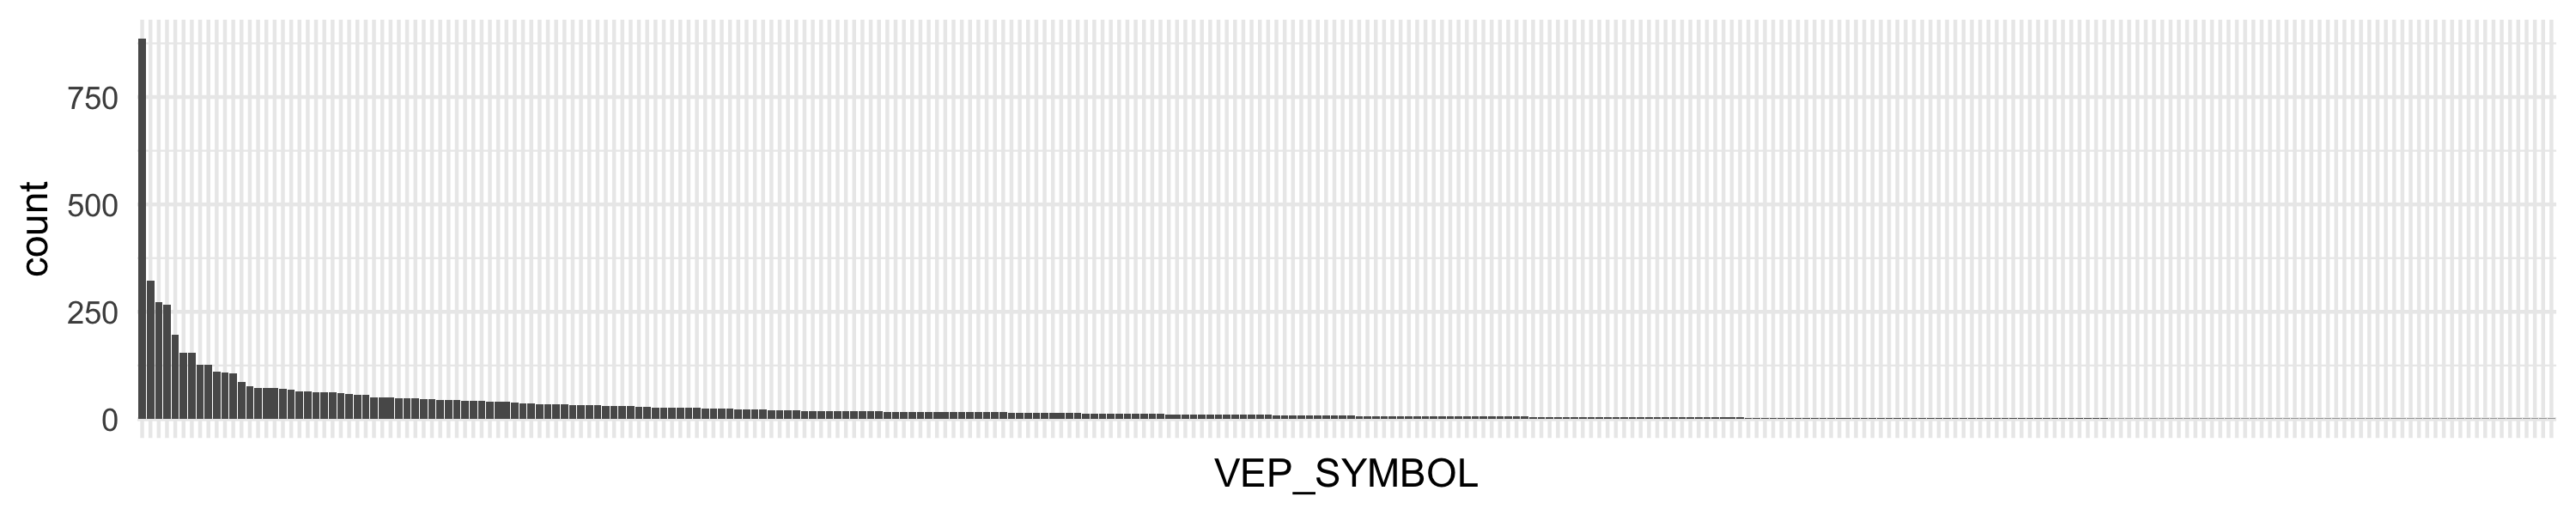

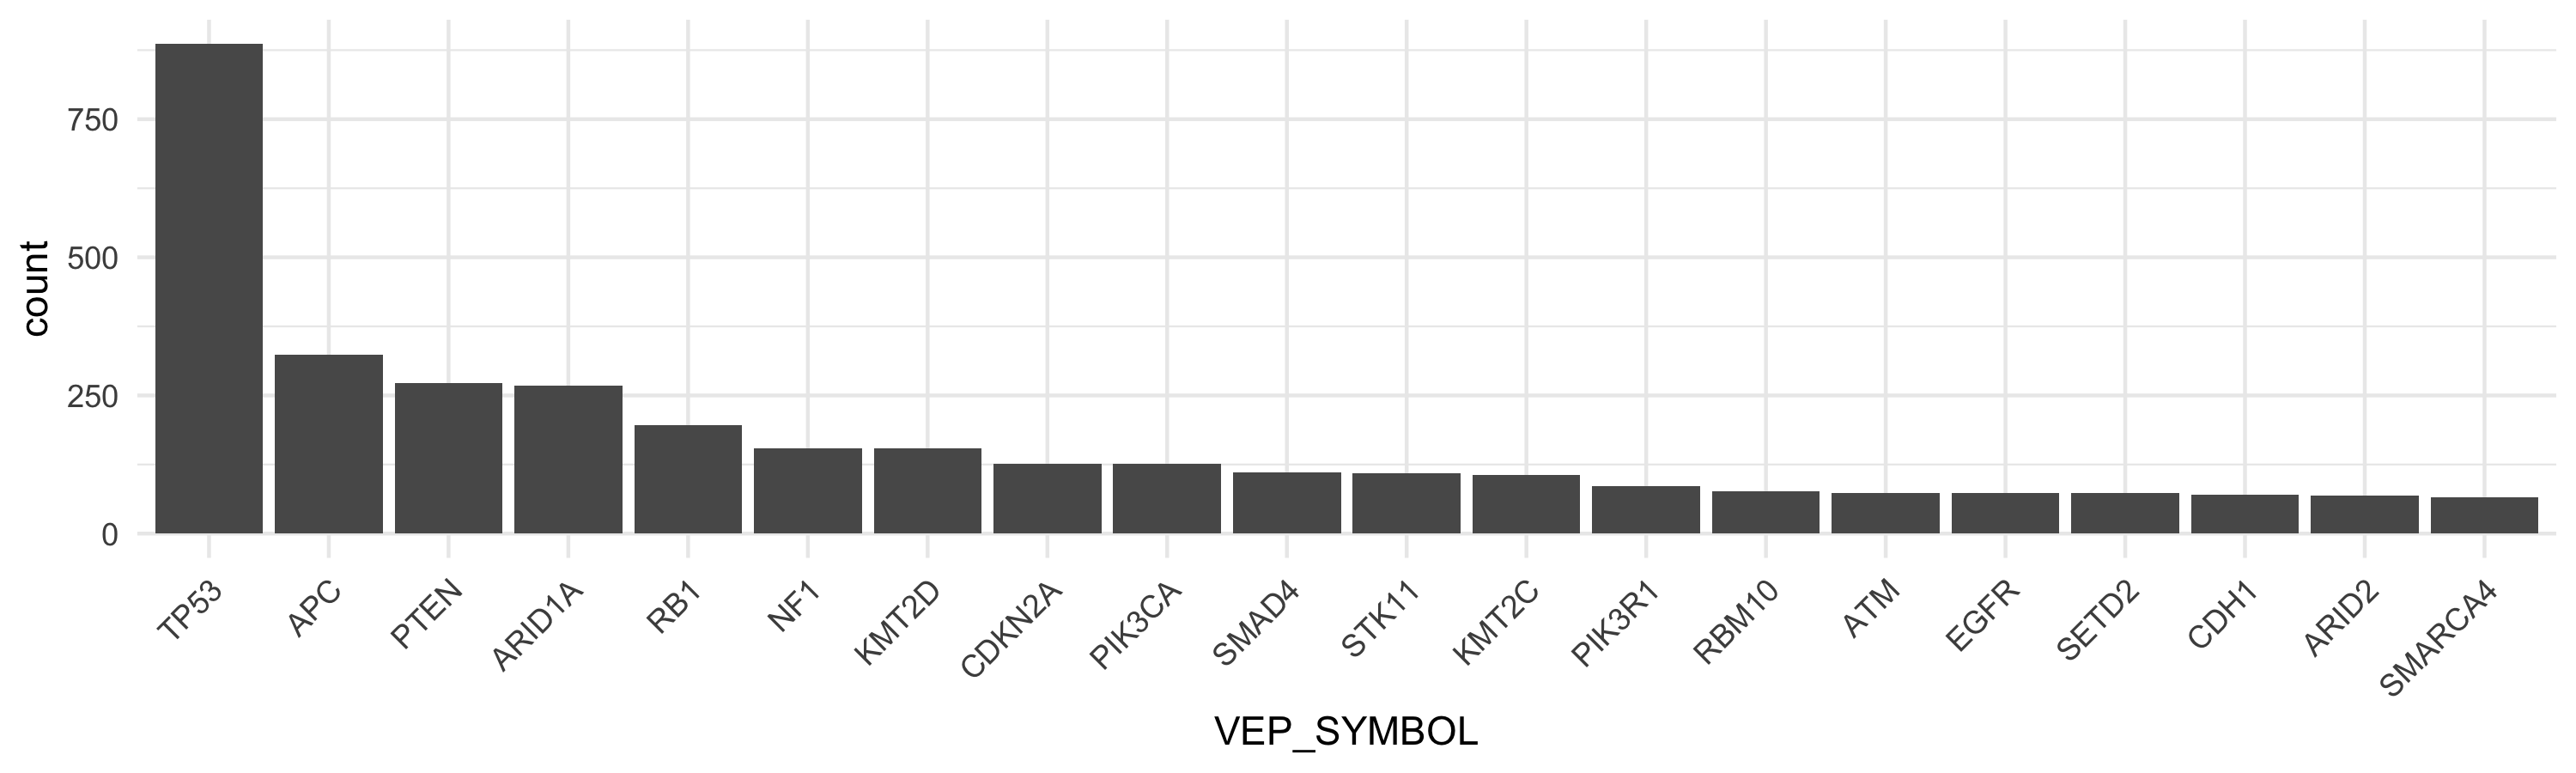

In [35]:
repeated_key <- sort_histogram(repeated_key, "VEP_SYMBOL")
set_notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(VEP_SYMBOL)) + theme(axis.text.x = element_blank())
plot_histogram_top(repeated_key, "VEP_SYMBOL", 20) + tilt_x_label(45)

Here is a plot of the genes that are the most mutated **accross the rows**:

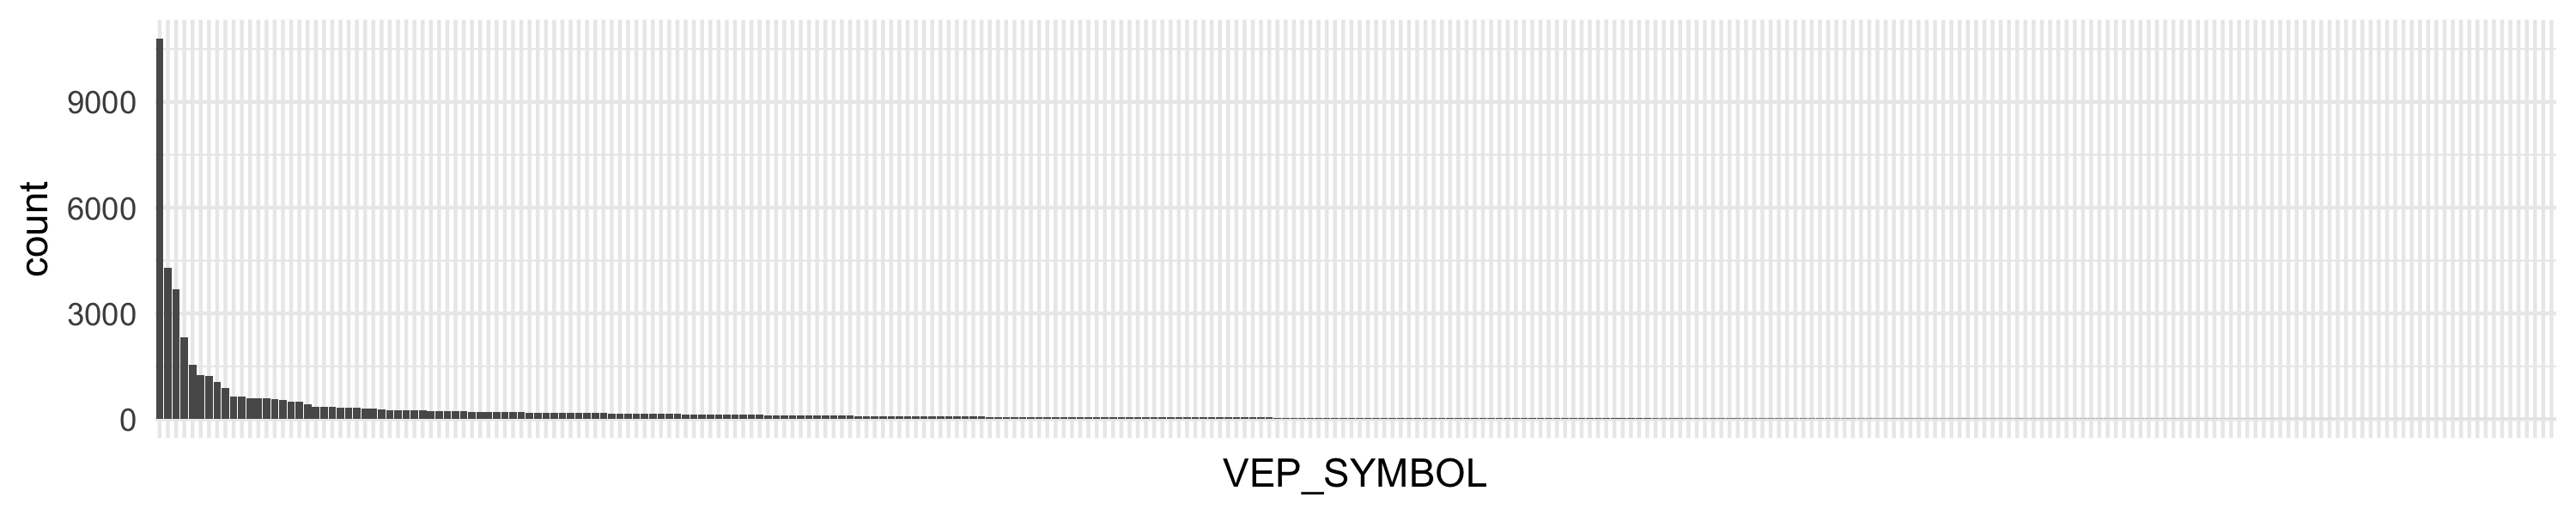

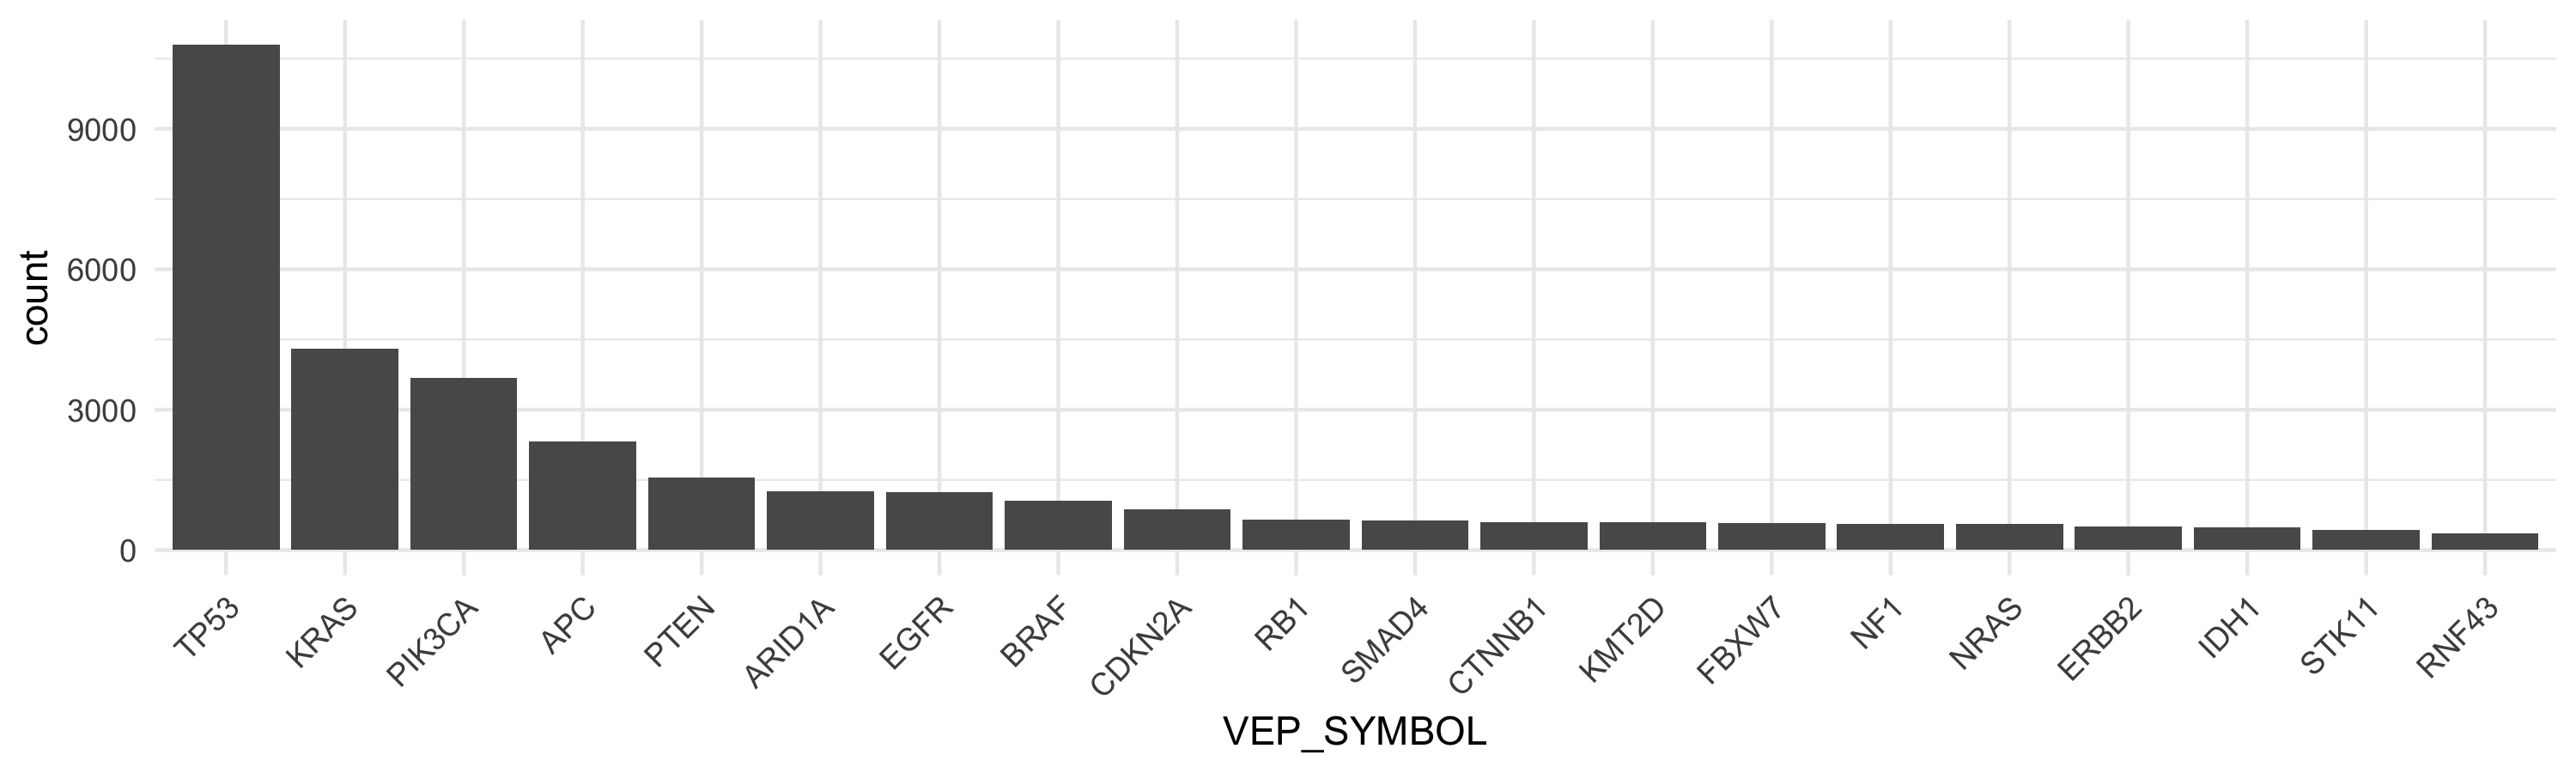

In [36]:
rec_impact <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% repeated_key$mut_key,]

rec_impact <- sort_histogram(rec_impact, "VEP_SYMBOL")
set_notebook_plot_size(10, 2)
ggplot(rec_impact) + geom_bar(aes(VEP_SYMBOL)) + theme(axis.text.x = element_blank())
plot_histogram_top(rec_impact, "VEP_SYMBOL", 20) + tilt_x_label(45)

# Study of `is_a_hostpost`, `is_a_3d_hostpot`

We won't study the `is_a_3d_hotspot` feature as it is mostly included in the `is_a_hostpot` feature:

[1] "1046 over 225022 (0.46%)"

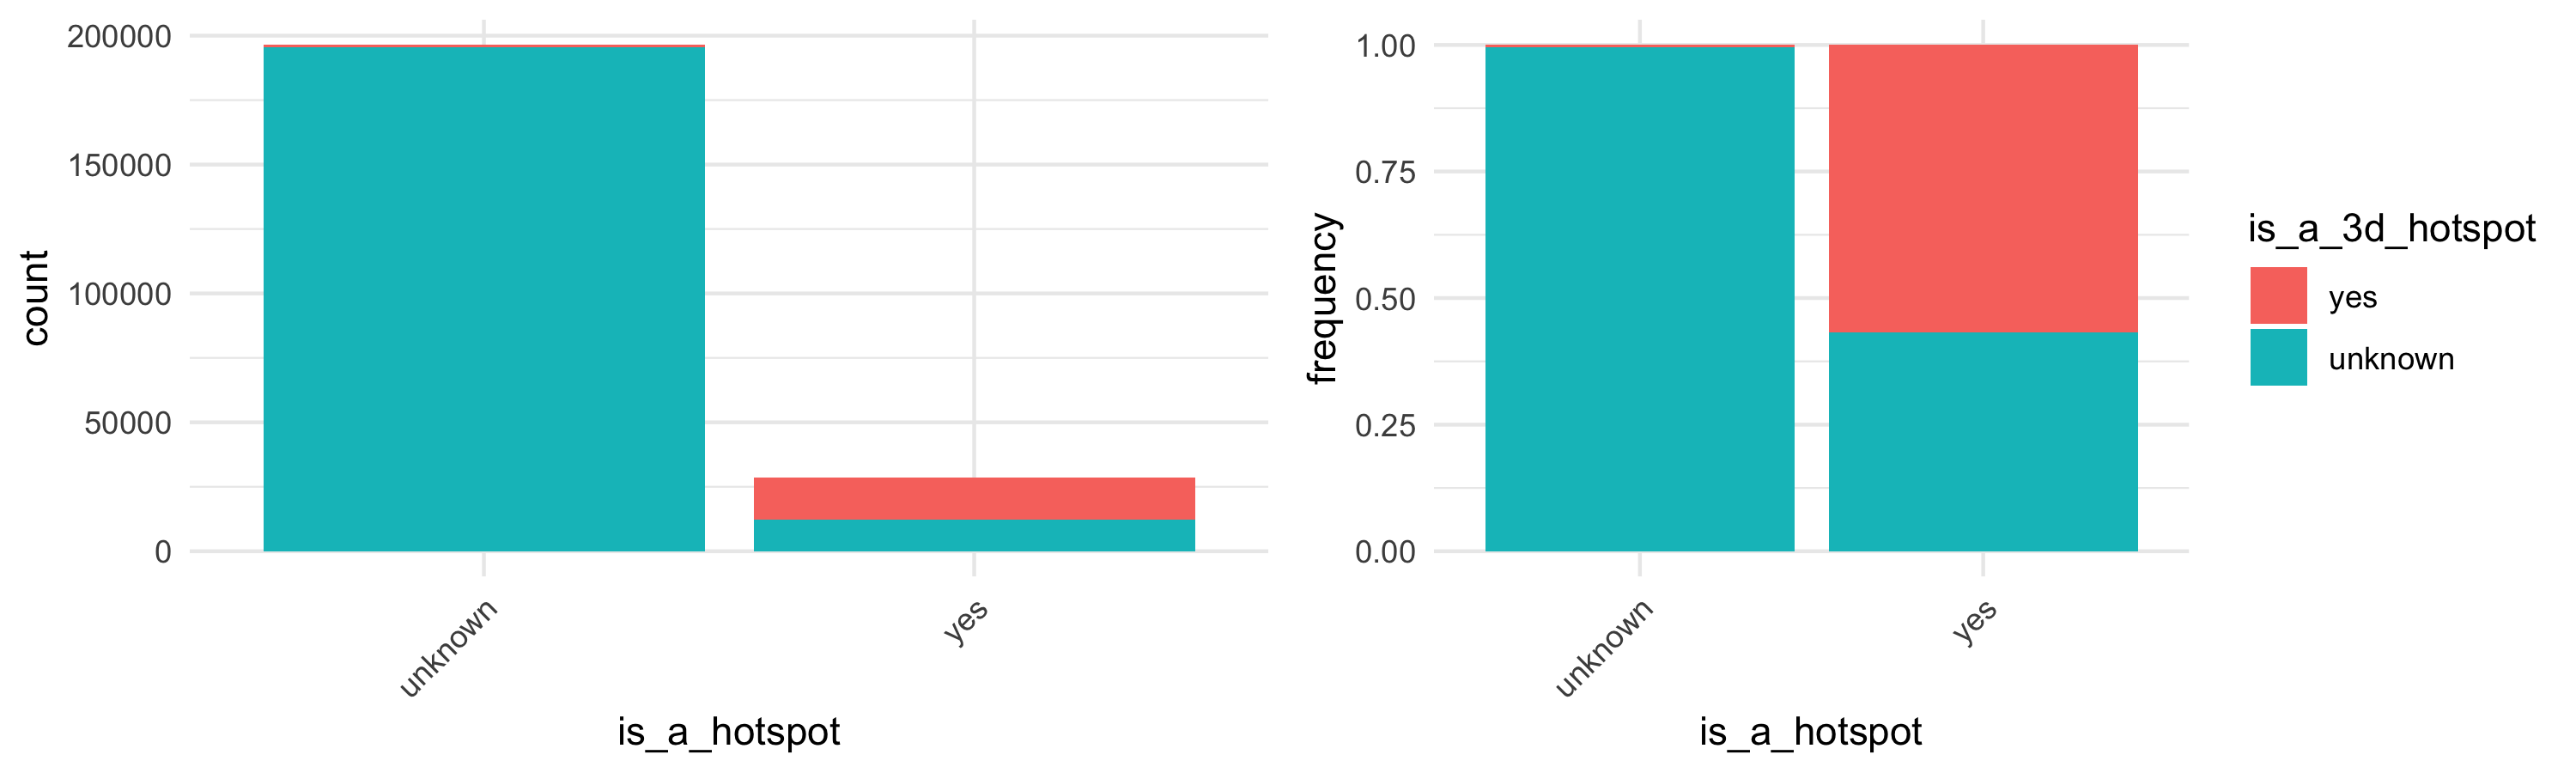

In [37]:
# number of 3d_hotspot mutations not being simple hotspot among the dataset
print_count_and_proportion(nrow(impact[impact$is_a_3d_hotspot == "yes" & impact$is_a_hotspot == "unknown",]),
                           nrow(impact))
plot_contingency_table_as_histograms(impact, "is_a_hotspot", "is_a_3d_hotspot")

It seems that the hostpot study focuses only on the `nonsynonymous_SNV` mutations:


unknown     yes 
 196408   28614 

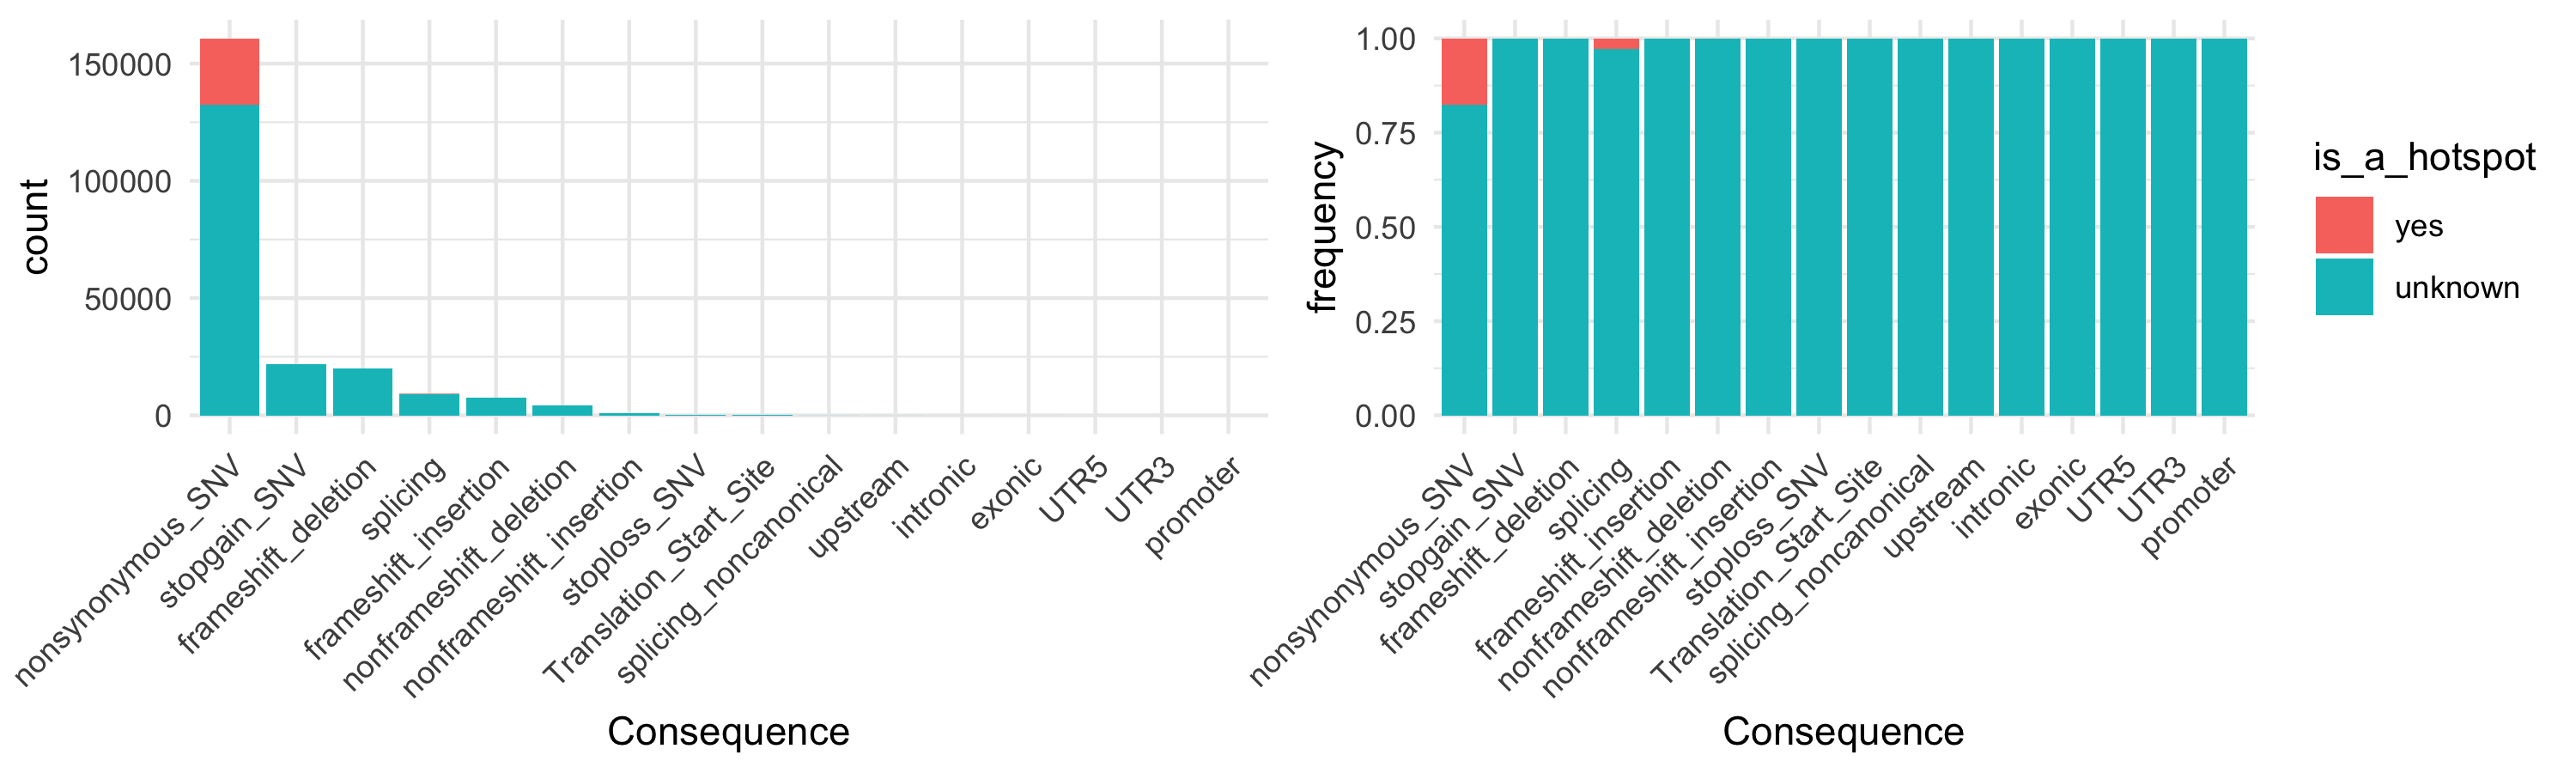

In [38]:
table(impact$is_a_hotspot)
plot_contingency_table_as_histograms(impact, "Consequence", "is_a_hotspot")

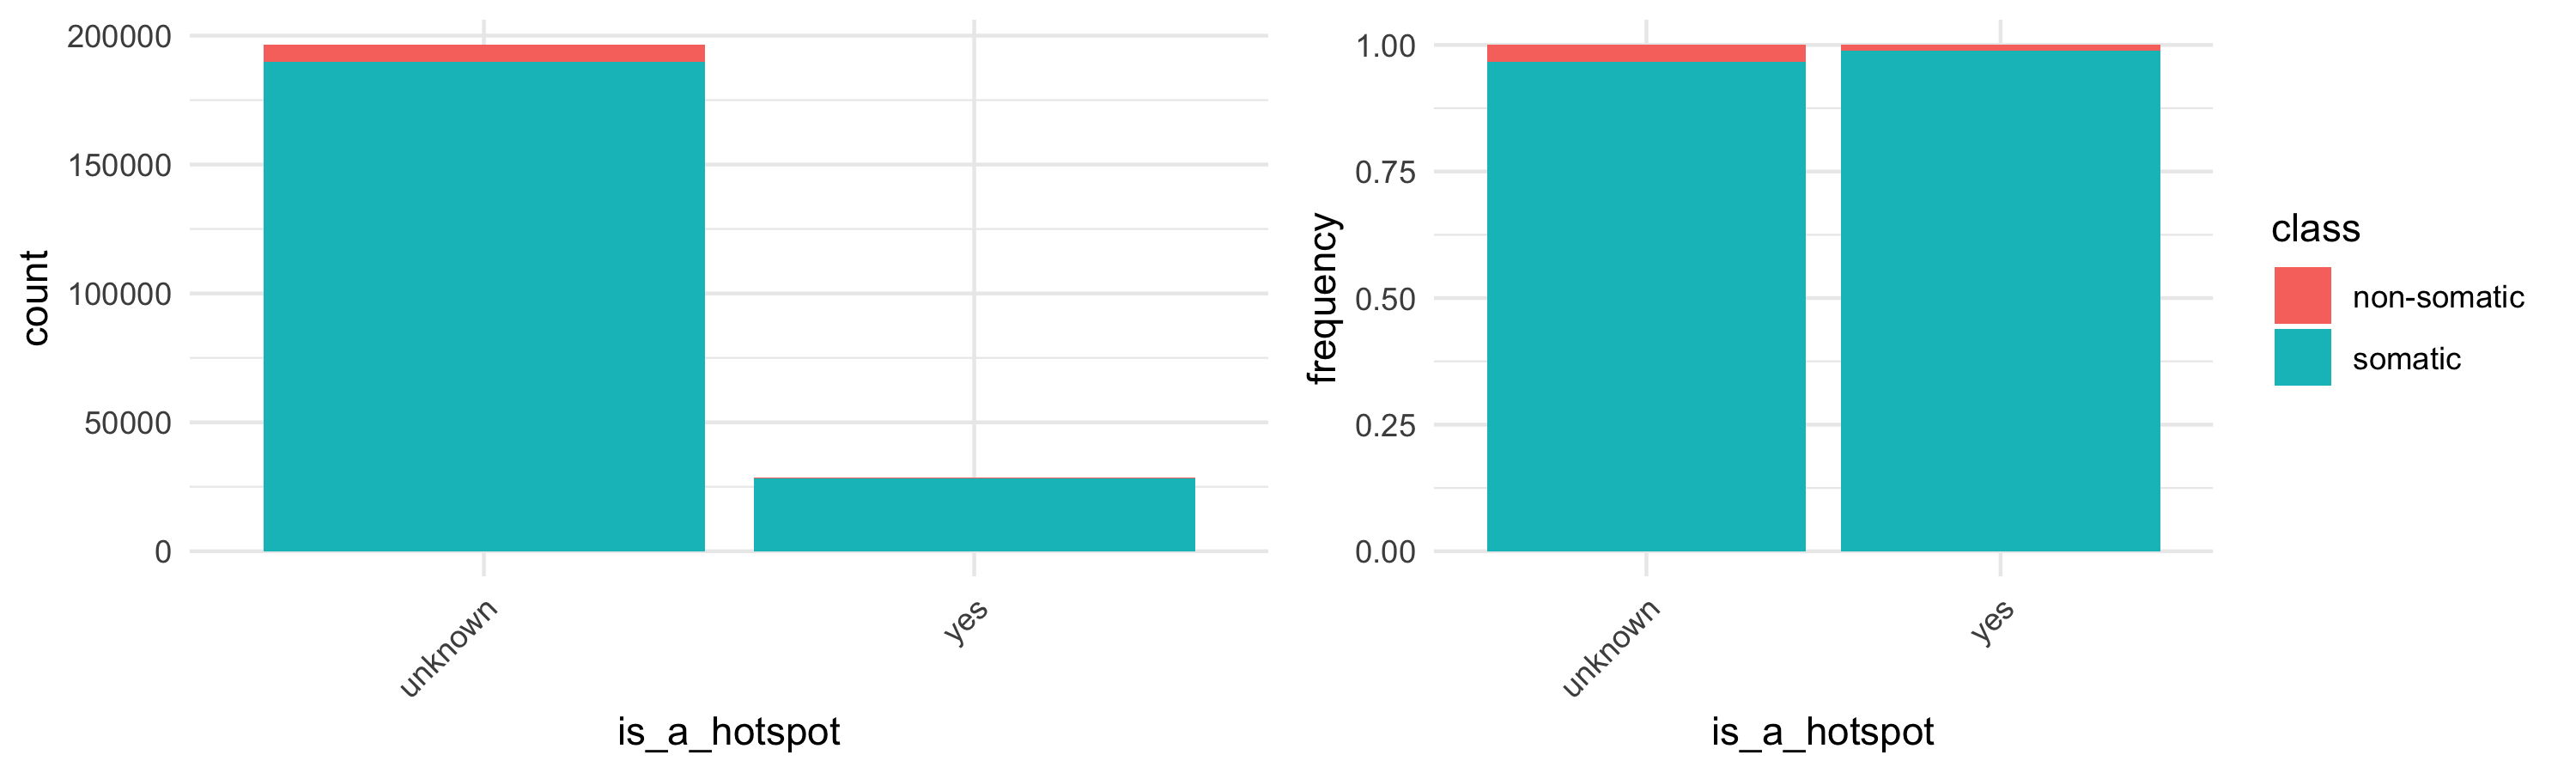

In [39]:
plot_contingency_table_as_histograms(impact[impact$class != "unknown",], "is_a_hotspot", "class")

Every variant in cancerhotspot is in OncoKB:

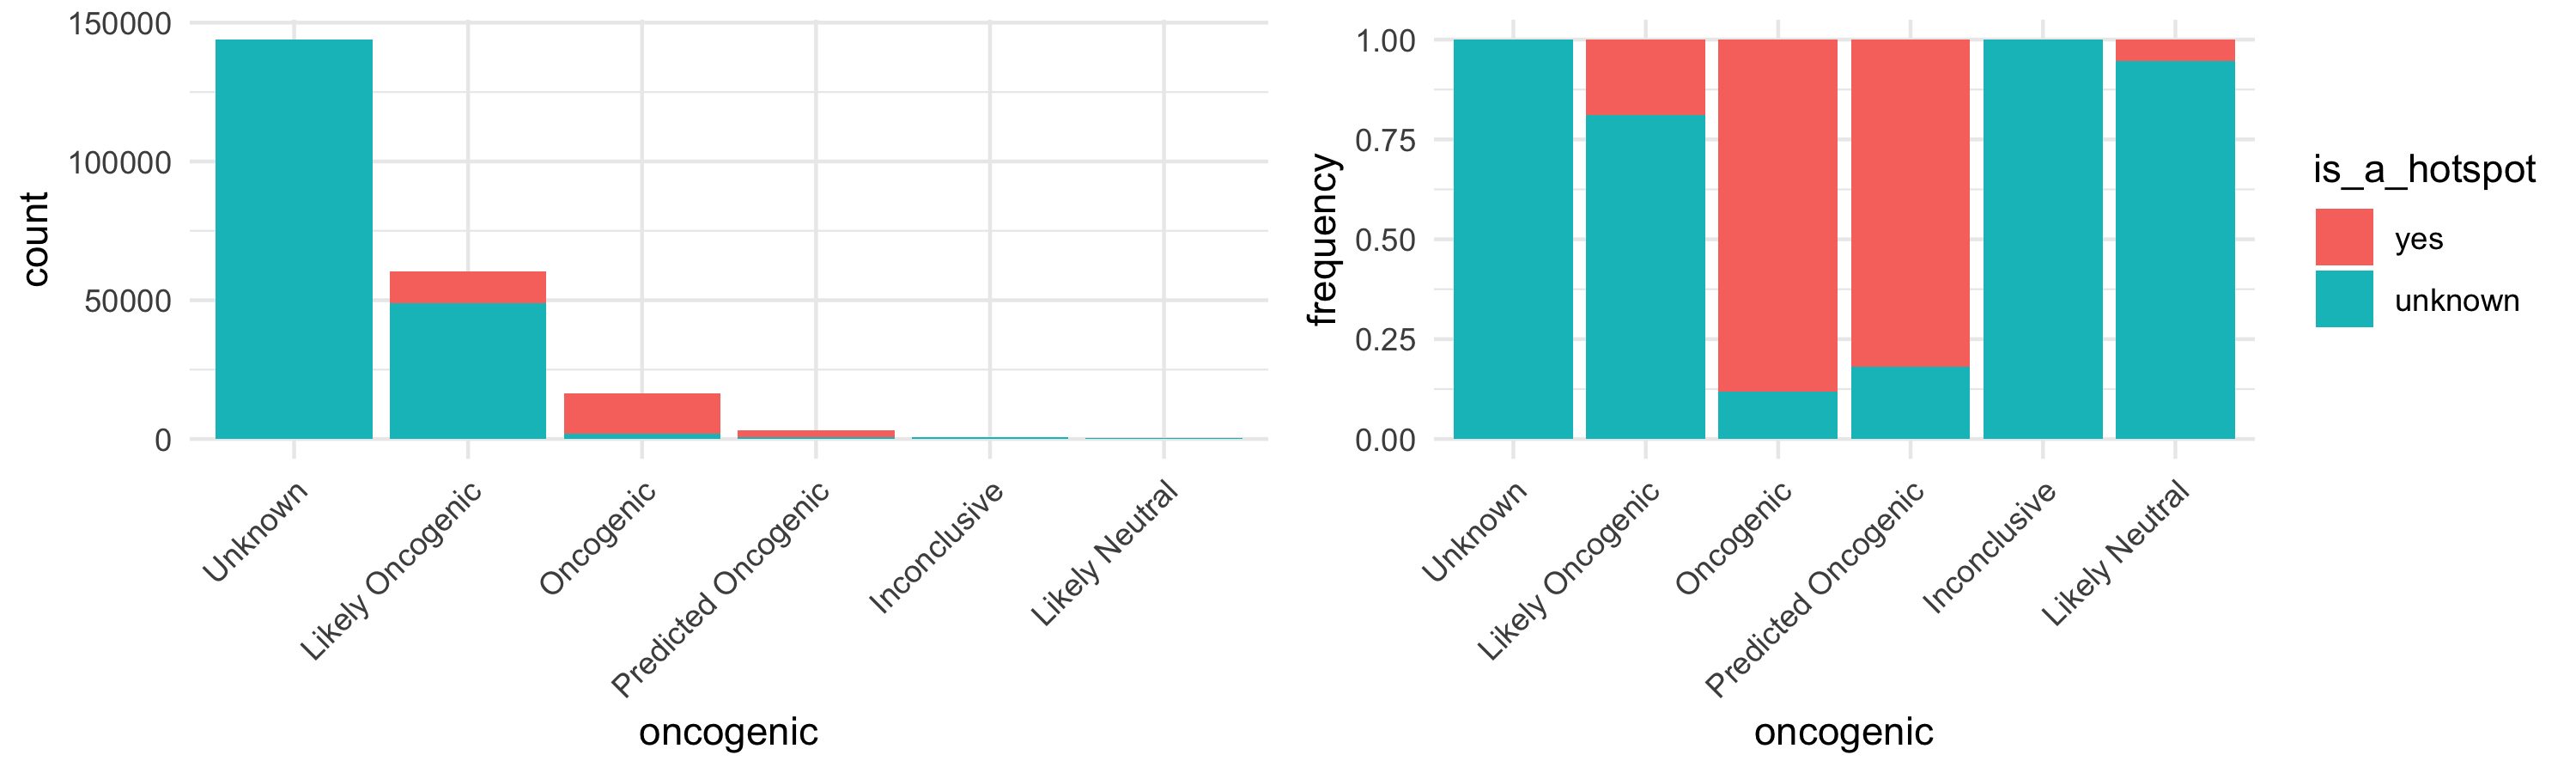

In [40]:
plot_contingency_table_as_histograms(impact, "oncogenic", "is_a_hotspot")

In [41]:
impact %>% filter(driver == "no" & is_a_hotspot == "yes") %>%
           group_by(mut_key) %>%
           summarise(count = n(),
                     Hugo_Symbol = unique(Hugo_Symbol),
                     HGVSp_Short = unique(HGVSp_Short),
                     oncogenic = unique(oncogenic))

mut_key             count Hugo_Symbol HGVSp_Short       oncogenic     
1 14_65544745_CCC_TTT 1     MAX         p.R60_A61delinsQT Unknown       
2 3_178916957_G_A     2     PIK3CA      p.R115Q           Likely Neutral
3 3_178916957_G_C     5     PIK3CA      p.R115P           Likely Neutral
4 3_178916957_G_T     4     PIK3CA      p.R115L           Likely Neutral
5 3_178922321_G_A     7     PIK3CA      p.G364R           Likely Neutral
6 3_178922322_G_C     1     PIK3CA      p.G364A           Likely Neutral
7 7_55224307_C_A      1     EGFR        p.T363N           Likely Neutral
8 7_55224307_C_T      1     EGFR        p.T363I           Likely Neutral

# Study of `gene_type`

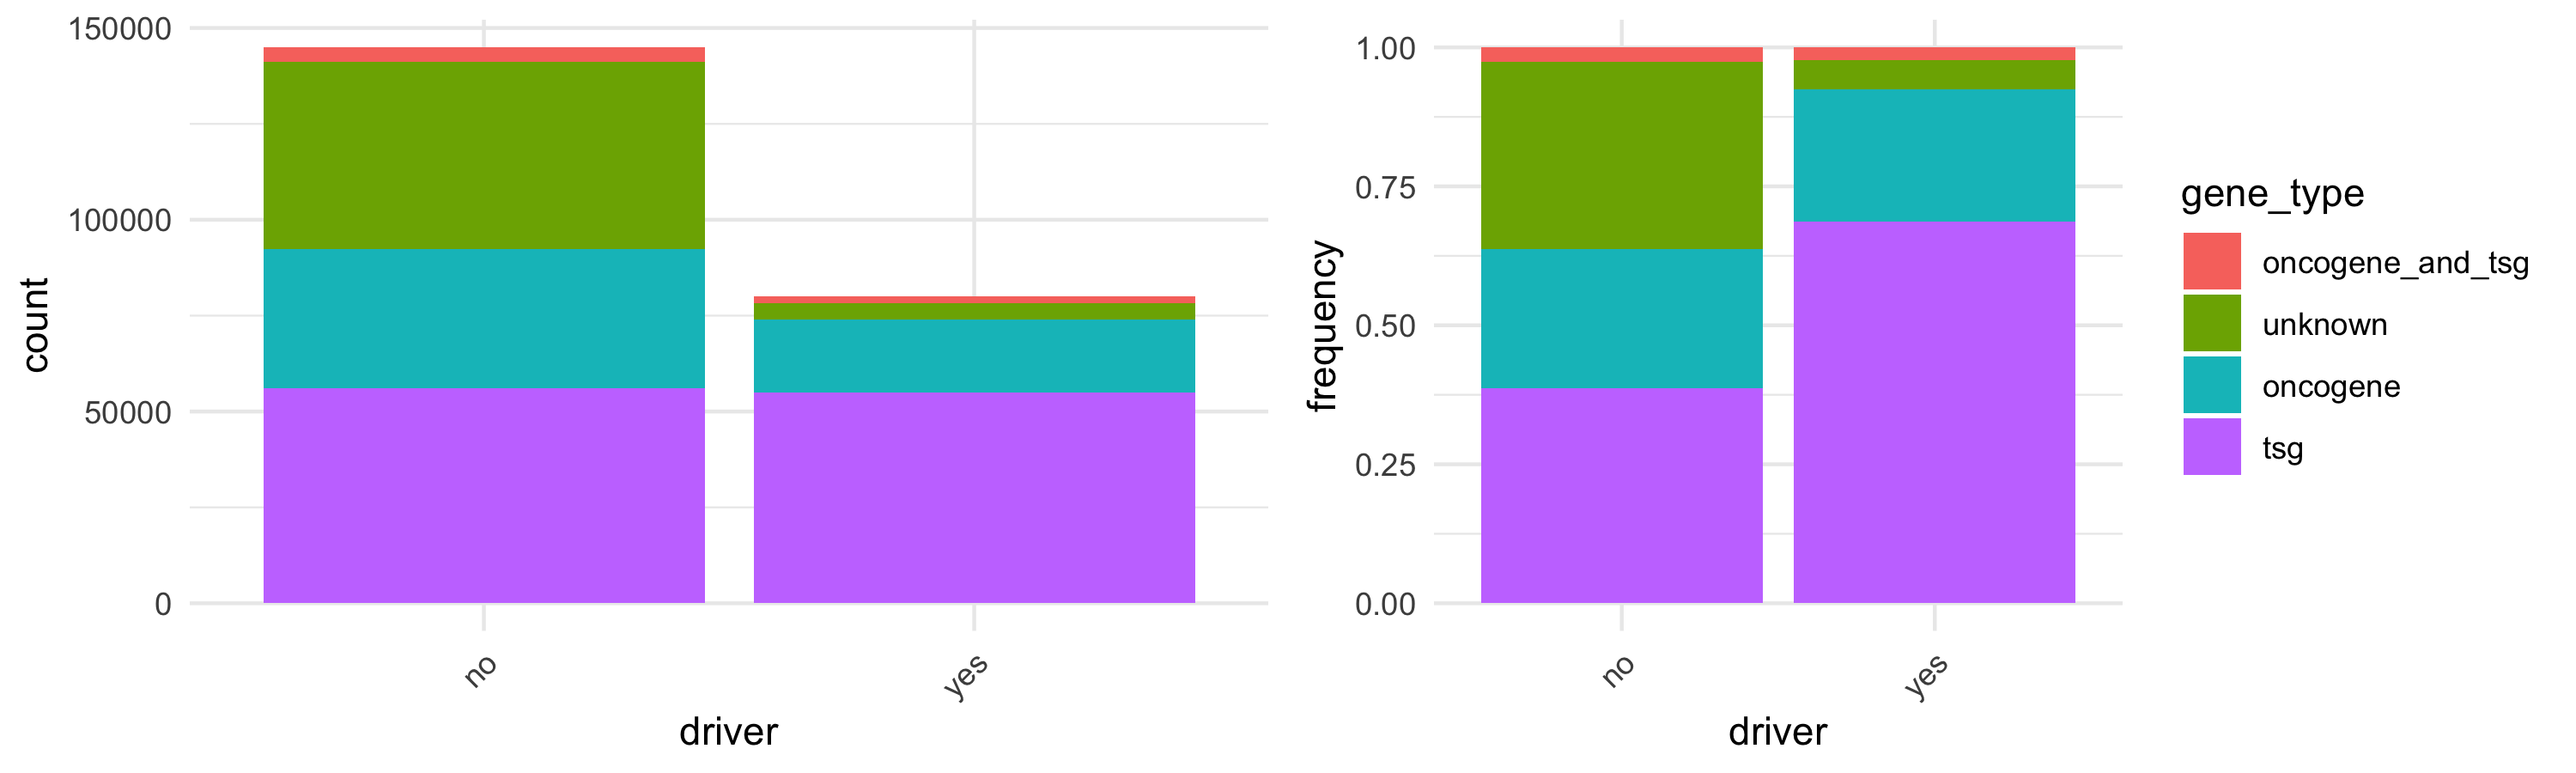

In [42]:
plot_contingency_table_as_histograms(impact, "driver", "gene_type")

Just a few variants are not in oncoKB but are truncated events in TSG genes:

In [43]:
truncating_mutations <- c("frameshift_deletion", "frameshift_insertion", "stopgain_SNV", "splicing")

# number of truncating event in TSG genes not being driver among the truncating event in TSG genes
trunc_tsg_but_not_drivers <- impact[impact$Consequence %in% truncating_mutations &
                                    impact$gene_type == "tsg" &
                                    impact$driver == "no",]

print_count_and_proportion(nrow(trunc_tsg_but_not_drivers), nrow(impact[impact$Consequence %in% truncating_mutations &
                                                                        impact$gene_type == "tsg",]))
table(trunc_tsg_but_not_drivers$Hugo_Symbol)

[1] "482 over 41404 (1.16%)"


       ANKRD11            APC         ARID1A         ARID1B          ARID2 
             1              5              3             11              1 
         ASXL1          ASXL2            ATM            ATR           ATRX 
             3              5             24              2              1 
         AXIN2            B2M           BAP1          BARD1        BCL2L11 
             5              3             10              3              1 
          BCOR            BLM          BRCA1          BRCA2          BRIP1 
             1              6              3              3              2 
         CASP8            CBL          CDC73           CDH1         CDKN1A 
             3              2              2              2              2 
  CDKN2Ap14ARF CDKN2Ap16INK4A          CHEK2            CIC         CREBBP 
             4              3              5              1              3 
          CTCF           DAXX         DICER1         DNMT3A          EP300 
           

# Annotate without oncokb-annotator

We are going to try to annotate our dataset without using oncokb-annotator but rather "by hand" using the raw OncoKB dataset dowloaded [here](http://oncokb.org/#/dataAccess) (blue button "ALL VARIANTS") on 06/08/18. We follow the methodology described in `annotate_cleaned_dataset.ipynb`.

## Get the raw data

In [44]:
oncokb <- read.table("../../data/other_databases/allAnnotatedVariants.txt",
                     sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

The line 3790 have two extra `3'` coming from nowhere, we remove them (it causes the importation to fail if we don't add `fill = TRUE` to `read.table`).

In [45]:
oncokb[3790,]
(oncokb[3790,] <- oncokb[3790,] %>% mutate(Isoform         = "ENST00000263735",
                                           RefSeq          = "NM_002354.2",
                                           Entrez.Gene.ID  = 4072,
                                           Gene            = "EPCAM",
                                           Alteration      = "Deletion",
                                           Protein.Change  = "Deletion",
                                           Oncogenicity    = "Oncogenic",
                                           Mutation.Effect = "Loss-of-function"))

Isoform         RefSeq      Entrez.Gene.ID Gene  Alteration Protein.Change
3790 ENST00000326873 NM_000455.4 6794           STK11 W308C      W308C         
     Oncogenicity     Mutation.Effect  PMIDs.for.Mutation.Effect
3790 Likely Oncogenic Loss-of-function 9837816, 15987703        
     Abstracts.for.Mutation.Effect
3790

Isoform         RefSeq      Entrez.Gene.ID Gene  Alteration Protein.Change
1 ENST00000263735 NM_002354.2 4072           EPCAM Deletion   Deletion      
  Oncogenicity Mutation.Effect  PMIDs.for.Mutation.Effect
1 Oncogenic    Loss-of-function 9837816, 15987703        
  Abstracts.for.Mutation.Effect
1

In [46]:
head(oncokb)

Isoform         RefSeq      Entrez.Gene.ID Gene Alteration     
1 ENST00000318560 NM_005157.4 25             ABL1 BCR-ABL1 Fusion
2 ENST00000318560 NM_005157.4 25             ABL1 D276G          
3 ENST00000318560 NM_005157.4 25             ABL1 E255K          
4 ENST00000318560 NM_005157.4 25             ABL1 E255V          
5 ENST00000318560 NM_005157.4 25             ABL1 E279K          
6 ENST00000318560 NM_005157.4 25             ABL1 E281K          
  Protein.Change  Oncogenicity     Mutation.Effect        
1 BCR-ABL1 Fusion Oncogenic        Gain-of-function       
2 D276G           Oncogenic        Gain-of-function       
3 E255K           Likely Oncogenic Likely Gain-of-function
4 E255V           Likely Oncogenic Likely Gain-of-function
5 E279K           Likely Oncogenic Likely Gain-of-function
6 E281K           Likely Oncogenic Likely Gain-of-function
  PMIDs.for.Mutation.Effect Abstracts.for.Mutation.Effect
1 11345193, 18851712                                     
2 15510211                                               
3 15194504                                               
4 21562040                                               
5 21562040                                               
6 21193419

##  Create keys to join the two dataframes and extract the features

We are going to identify each mutation with a key in both dataframes, allowing us to link each mutation from `impact` to its corresponding mutation in `oncokb`. The keys will be: 
* `Hugo_Symbol`.`HGVSp_Short` for `impact` or `Hugo_Symbol`.p.`Truncating Mutations` when the mutation is truncating (OncoKB notation)
* `Gene`.p.`Protein.Change` for `oncokb`

In [47]:
# create the oncokb `join_key`
oncokb$join_key <- paste0(oncokb$Gene, '.p.',oncokb$Protein.Change)

# create the impact `oncokb_key`
impact$oncokb_key <- paste0(impact$Hugo_Symbol, '.', impact$HGVSp_Short)

is_truncating <- which(impact$Consequence %in% c("frameshift_deletion",
                                                 "frameshift_insertion",
                                                 "stopgain_SNV",
                                                 "splicing"))
impact$oncokb_key[is_truncating] <- paste0(impact$Hugo_Symbol[is_truncating], '.p.Truncating Mutations')

In [48]:
head(oncokb$join_key)
head(impact$oncokb_key)

[1] "ABL1.p.BCR-ABL1 Fusion" "ABL1.p.D276G"           "ABL1.p.E255K"          
[4] "ABL1.p.E255V"           "ABL1.p.E279K"           "ABL1.p.E281K"

[1] "TP53.p.T256P"                 "PIK3R3.p.I298M"              
[3] "ATR.p.R2431M"                 "PDGFRA.p.L465M"              
[5] "FBXW7.p.Truncating Mutations" "FBXW7.p.Truncating Mutations"

**Verification 1** The feature `Oncogenicity` is unique for each `join_key`:

In [49]:
nrow(oncokb %>% group_by(join_key) %>% filter(length(unique(Oncogenicity)) > 1))
oncokb <- unique(oncokb[, c("join_key", "Oncogenicity")])
head(oncokb, 4)

[1] 0

join_key               Oncogenicity    
1 ABL1.p.BCR-ABL1 Fusion Oncogenic       
2 ABL1.p.D276G           Oncogenic       
3 ABL1.p.E255K           Likely Oncogenic
4 ABL1.p.E255V           Likely Oncogenic

**Verification 2** Some impact `oncokb_key` don't have an analoguous `join_key` in `oncokb`, some `NA` values will appear and need to be handled:

In [50]:
nrow(impact[! impact$oncokb_key %in% oncokb$join_key,])

[1] 156719

In [51]:
impact[, c("oncogenicity")] <- left_join(impact, oncokb,
                                         by = c("oncokb_key" = "join_key"))[, c("Oncogenicity")]

## Compare `oncogenicity` with `oncogenic`

In [52]:
impact$oncogenicity[is.na(impact$oncogenicity)] <- "Unknown"
table(impact$oncogenicity)


    Inconclusive   Likely Neutral Likely Oncogenic        Oncogenic 
             527              213            51700            15863 
         Unknown 
          156719 

Let's compare oncokb-annotator with our raw linking:

In [53]:
print_count_and_proportion(nrow(impact[impact$oncogenic    != "Unknown",]), nrow(impact))
print_count_and_proportion(nrow(impact[impact$oncogenicity != "Unknown",]), nrow(impact))

[1] "81121 over 225022 (36.05%)"

[1] "68303 over 225022 (30.35%)"

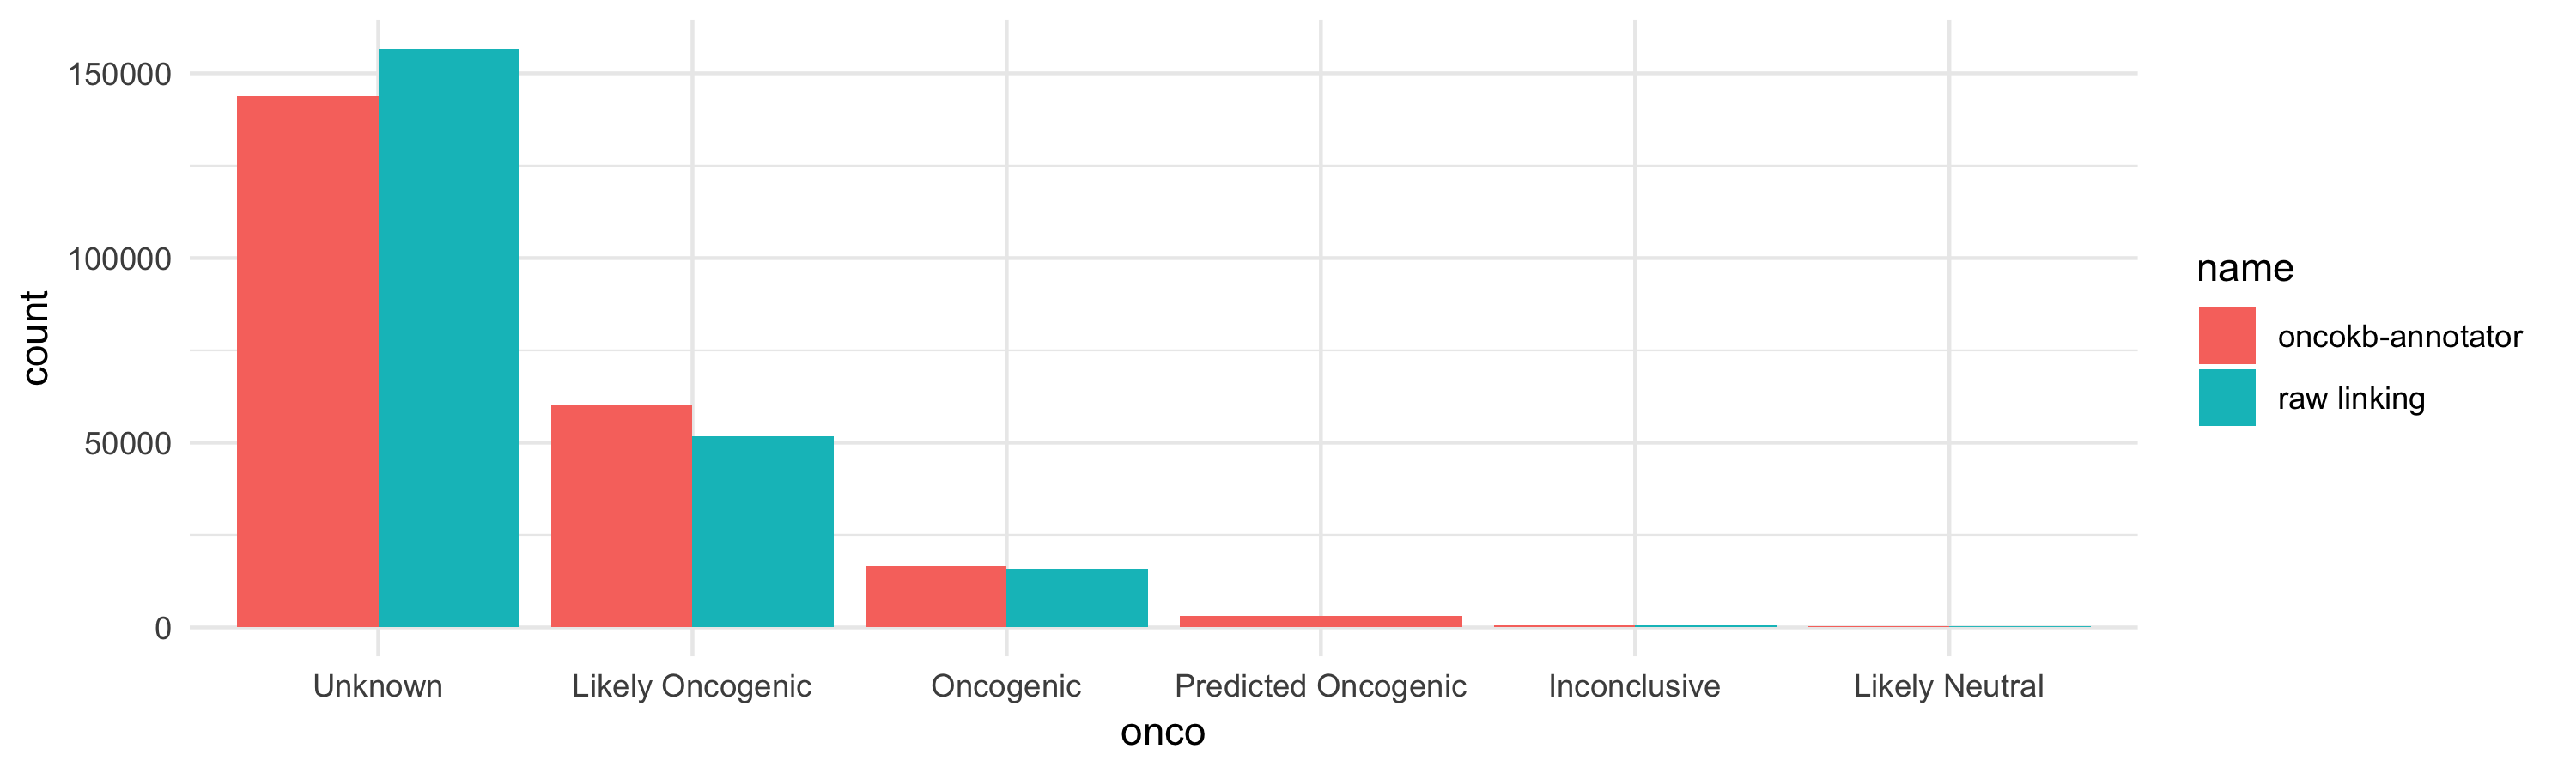

In [54]:
dd_1 <- data.frame(impact$oncogenic, "oncokb-annotator")
colnames(dd_1) <- c("onco", "name")
dd_1 <- sort_histogram(dd_1, "onco")
dd_2 <- data.frame(impact$oncogenicity, "raw linking")
colnames(dd_2) <- c("onco", "name")
dd_2 <- sort_histogram(dd_2, "onco")

ggplot(rbind(dd_1, dd_2)) + geom_bar(aes(x = onco, fill = name), position = "dodge")

# Study of the alternative amino-acid

In this section we are going to study if the alternative amino-acid changes are also considered by oncokb-annotator, for example, if `SRSF2.p.P95H` is in OncoKB, is `SRSF2.p.P95R` also in OncoKB? It will only focus on the single acid substitution. The following function returns, for a given key, the list of the alternative amino-acid keys in OncoKB:

In [55]:
amino_acid_list = c('A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                    'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V')

get_alternative_keys_in_oncokb <- function(key) {

    # check if single acid substitution (p.T256P)
    if (grepl("\\.p\\.[A-Z][0-9]{1,4}[A-Z]$", key)) {

        alternative_amino_acid_list <- amino_acid_list[amino_acid_list != substr(key, nchar(key), nchar(key))]
        alternative_keys <- paste0(substr(key, 1, nchar(key)-1), alternative_amino_acid_list)
        in_oncokb <- which(alternative_keys %in% oncokb$join_key)
        
        if (any(alternative_keys %in% oncokb$join_key))
            return (c(key, alternative_keys[in_oncokb]))
    }
    
    return ('')
}

get_alternative_keys_in_oncokb("MAP2K4.p.S251A")
get_alternative_keys_in_oncokb("TP53.p.T256P")
get_alternative_keys_in_oncokb('FBXW7.p.Truncating Mutations')

[1] "MAP2K4.p.S251A" "MAP2K4.p.S251N"

[1] ""

[1] ""

Let's see if some of the unknown mutations would have been in OncoKB if they were resulting in an alternative amino_acid:

In [56]:
dd <- sapply(unique(impact$oncokb_key[impact$oncogenic == "Unknown"]), get_alternative_keys_in_oncokb)
dd <- unique(dd[dd != ''])
length(dd)

[1] 78

Apparently oncokb-annotator takes this into account.